In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mlflow
import mlflow.sklearn

from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

"Prêt à dépenser" is a financial company that offers consumer loans to individuals with little or no credit history. The company aims to develop a credit scoring tool that predicts the likelihood of a customer repaying their loan and classifies applications as either approved or rejected.

 - Version 0 : Data exploration and understanding of the main issues and challenges
 - Version 1 : Set a Baseline with LogisticRegression classifier, define a business appropriate metric. Analyse the effect of the LogisticRegression threshold. Balance classes. Analyse balancing classes effect on metrics.
 - Version 2 : Test bagging (Random Forest) and Boosting (ADABoost, GradientBoosting, XGBoost, LightGBM). Define and test a custom metric for gridsearchCV. Best model selection.

# Exploratory Data Analysis

In [5]:
# List of available files
print(os.listdir("./data/"))

['additional_data_bureau.csv', 'application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


Only the "application_test.csv" table will be used in a first approach.

In [7]:
# Main dataset
app_train = pd.read_csv('./data/application_train.csv')
app_train_master = app_train.copy()
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

## Target

Target = 0 => loan repaid

Target = 1 => loan not repaid

In [10]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

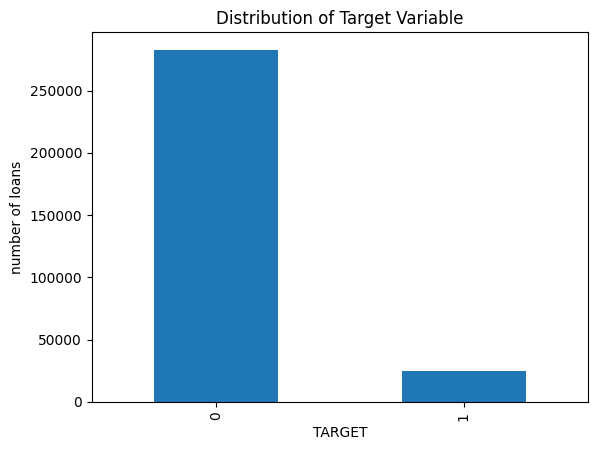

In [11]:
# Display target
app_train['TARGET'].value_counts().plot.bar();
plt.title('Distribution of Target Variable')
plt.ylabel('number of loans')
plt.show()

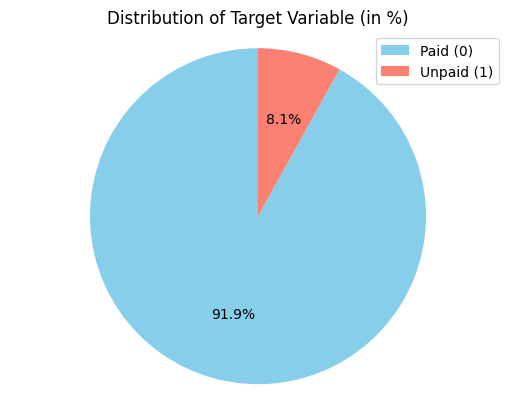

In [12]:
# Target Pie Chart with percentage display
plt.pie(app_train['TARGET'].value_counts(), autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Distribution of Target Variable (in %)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(['Paid (0)', 'Unpaid (1)'])
plt.show()

ccl : We see this is a very imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. It will be necessary to handle this imbalance with care.

## Columns

In [15]:
# Explore features
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

The "HomeCredit_columns_description.csv" table gives the definition of all features.

In [17]:
# Feature definition
col_desc = pd.read_csv('./data/HomeCredit_columns_description.csv', encoding='ISO-8859-1')
col_desc.head(5)

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

It will be usefull to access easily a feature definition. Let's write a function for this purpose.

In [19]:
# Function to find a feature definition
def feature_definition(feat_to_define, tab='application_{train|test}.csv'):
    mask = (col_desc['Row'] == feat_to_define) & (col_desc['Table'] == tab)
    print(f'Definition of feature "{feat_to_define}" : {col_desc.loc[mask , 'Description'].item()}')

feature_definition('FLAG_DOCUMENT_17')

Definition of feature "FLAG_DOCUMENT_17" : Did client provide document 17


## Examine Missing Values

In [21]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values and Percentage of missing values
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_df = pd.DataFrame(data={'Missing Values': mis_val,'% of Total Values': mis_val_percent})
    
    # Sort the table by percentage of missing descending
    mis_val_df = mis_val_df[mis_val_df.iloc[:,1] != 0].sort_values('% of Total Values',
                                                                   ascending=False).round(1)
        
    # Print some summary information
    print(f'Your selected dataframe has {df.shape[1]} columns.')
    print(f'There are {mis_val_df.shape[0]} columns that have missing values.')
    return mis_val_df

In [22]:
missing_values_table(app_train).head(15)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5

ccl : There are numerous missing values. A selection will be made later, after analyzing correlations.

## Column Types

In [25]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [26]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

ccl : There are 16 categorical features to work on.

## Encoding Categorical Variables

For any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

In [30]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            print(col)
            le.fit(app_train[col])            
            # Transform the selected data
            app_train[col] = le.transform(app_train[col])                       
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE
FLAG_OWN_CAR
FLAG_OWN_REALTY
3 columns were label encoded.


In [31]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
print('Training Features shape: ', app_train.shape)

Training Features shape:  (307511, 243)


## Anomalies

### Time related features

The numbers in the "DAYS_BIRTH" column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year.

In [35]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

There are no outliers for the age.

In [37]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

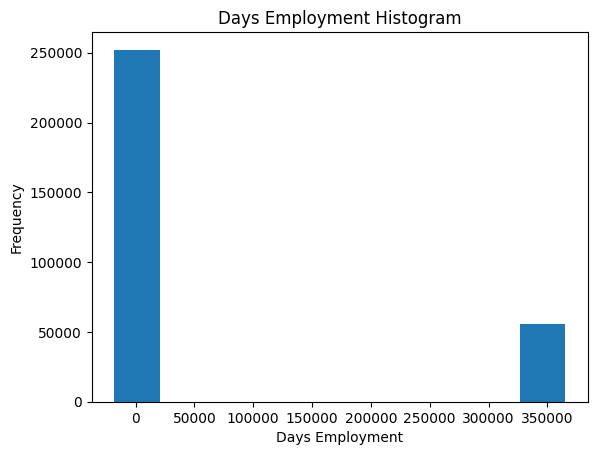

In [39]:
# Display "DAYS_EMPLOYED" feature
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

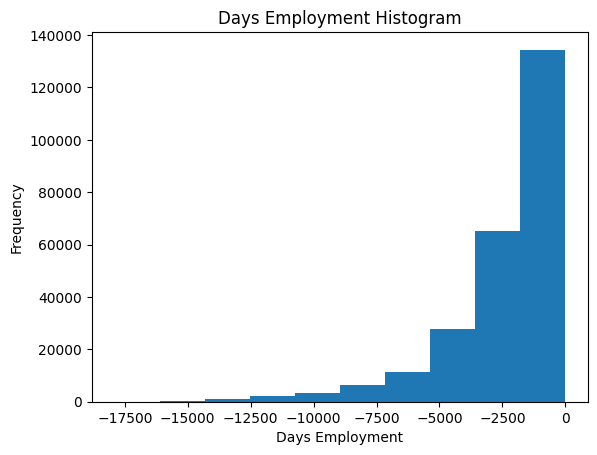

In [41]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Inverse features with negative days count

In [43]:
neg_feat_serie = (app_train < 0).sum(axis=0).sort_values(ascending=False)
neg_feat_serie[0:10]

DAYS_BIRTH                             307511
DAYS_ID_PUBLISH                        307495
DAYS_REGISTRATION                      307431
DAYS_LAST_PHONE_CHANGE                 269838
DAYS_EMPLOYED                          252135
SK_ID_CURR                                  0
WEEKDAY_APPR_PROCESS_START_SUNDAY           0
WEEKDAY_APPR_PROCESS_START_TUESDAY          0
WEEKDAY_APPR_PROCESS_START_THURSDAY         0
WEEKDAY_APPR_PROCESS_START_SATURDAY         0
dtype: int64

In [44]:
neg_feat_list = neg_feat_serie[neg_feat_serie != 0].index

for feat in neg_feat_list:
    app_train[feat] = -app_train[feat]
    print(f'{feat} has been inversed')   

DAYS_BIRTH has been inversed
DAYS_ID_PUBLISH has been inversed
DAYS_REGISTRATION has been inversed
DAYS_LAST_PHONE_CHANGE has been inversed
DAYS_EMPLOYED has been inversed


In [45]:
# Verification
app_train[neg_feat_list].head()

DAYS_BIRTH  DAYS_ID_PUBLISH  DAYS_REGISTRATION  DAYS_LAST_PHONE_CHANGE  \
0        9461             2120             3648.0                  1134.0   
1       16765              291             1186.0                   828.0   
2       19046             2531             4260.0                   815.0   
3       19005             2437             9833.0                   617.0   
4       19932             3458             4311.0                  1106.0   

   DAYS_EMPLOYED  
0          637.0  
1         1188.0  
2          225.0  
3         3039.0  
4         3038.0

In [46]:
# Checking statistical consistency of time related features
app_train[neg_feat_list].describe()

DAYS_BIRTH  DAYS_ID_PUBLISH  DAYS_REGISTRATION  \
count  307511.000000    307511.000000      307511.000000   
mean    16036.995067      2994.202373        4986.120328   
std      4363.988632      1509.450419        3522.886321   
min      7489.000000         0.000000          -0.000000   
25%     12413.000000      1720.000000        2010.000000   
50%     15750.000000      3254.000000        4504.000000   
75%     19682.000000      4299.000000        7479.500000   
max     25229.000000      7197.000000       24672.000000   

       DAYS_LAST_PHONE_CHANGE  DAYS_EMPLOYED  
count           307510.000000  252137.000000  
mean               962.858788    2384.169325  
std                826.808487    2338.360162  
min                 -0.000000      -0.000000  
25%                274.000000     767.000000  
50%                757.000000    1648.000000  
75%               1570.000000    3175.000000  
max               4292.000000   17912.000000

ccl : no outliers detected

### Financial features

Financial features may play a crucial role in determining the probability of loan repayment. Let's take a closer look at these features.

In [50]:
# Verify "AMT_INCOME_TOTAL" feature
app_train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

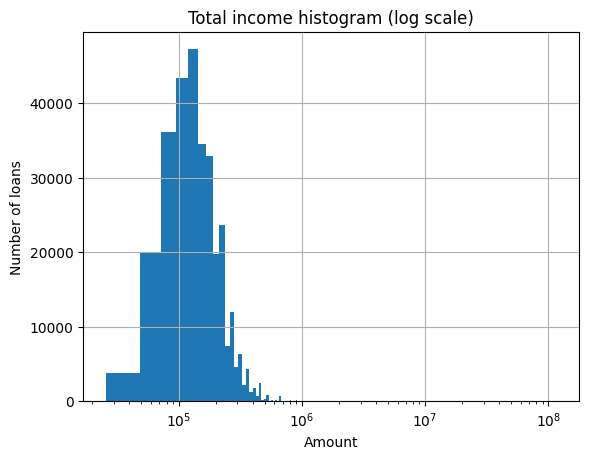

In [51]:
# Display the "AMT_INCOME_TOTAL" feature
plt.hist(app_train['AMT_INCOME_TOTAL'], bins=5000)
plt.title('Total income histogram (log scale)')
plt.xscale('log')
plt.xlabel('Amount')
plt.ylabel('Number of loans')
plt.grid()
plt.show()

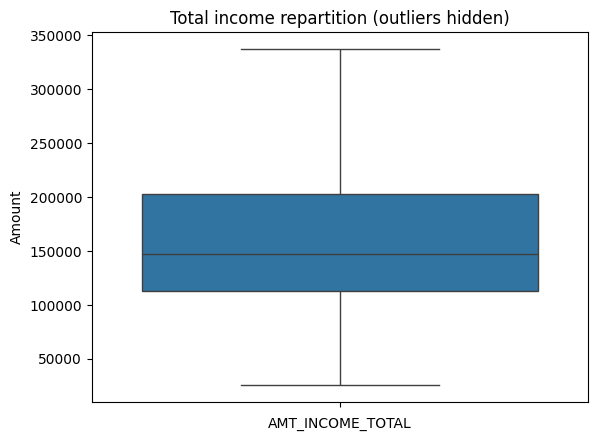

In [52]:
# "AMT_INCOME_TOTAL" boxplot
sns.boxplot(y=app_train['AMT_INCOME_TOTAL'], showfliers=False)
plt.xlabel('AMT_INCOME_TOTAL')
plt.ylabel('Amount')
plt.title('Total income repartition (outliers hidden)')
plt.show()

In [53]:
# Checking statistical consistency of financial related features
app_train.iloc[:,5:9].describe()

CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY
count  307511.000000      3.075110e+05  3.075110e+05  307499.000000
mean        0.417052      1.687979e+05  5.990260e+05   27108.573909
std         0.722121      2.371231e+05  4.024908e+05   14493.737315
min         0.000000      2.565000e+04  4.500000e+04    1615.500000
25%         0.000000      1.125000e+05  2.700000e+05   16524.000000
50%         0.000000      1.471500e+05  5.135310e+05   24903.000000
75%         1.000000      2.025000e+05  8.086500e+05   34596.000000
max        19.000000      1.170000e+08  4.050000e+06  258025.500000

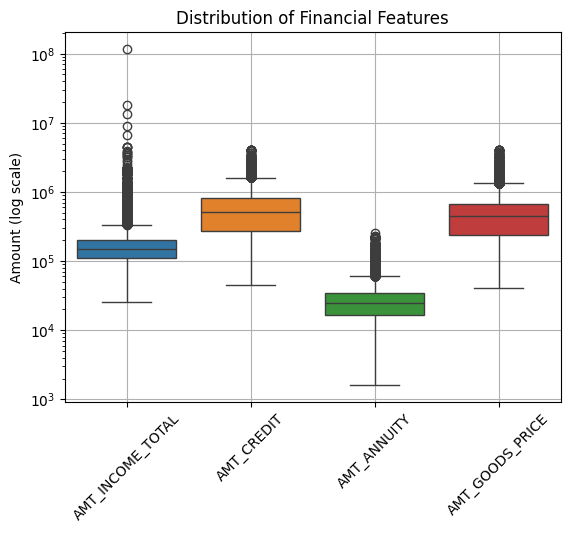

In [54]:
# Display and copmpare all financial features, with outliers
data = app_train.iloc[:, 6:10]

sns.boxplot(data=data, showfliers=True)
plt.ylabel('Amount (log scale)')
plt.title('Distribution of Financial Features')
plt.xticks(rotation=45)
plt.yscale('log')
plt.grid(True)
plt.show()

ccl : No outliers found in financial features

### Other features

In [57]:
# Sweep through all the features
n = -20

In [58]:
# Run again this celle the sweep through all the features
n = n + 20
app_train.iloc[: , n:n+20].sample(5)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
28515       133143       0                   0             0                1   
305678      454156       0                   0             0                1   
16304       119017       0                   0             1                0   
17443       120345       0                   0             1                1   
44024       150984       0                   0             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
28515              0          225000.0    254700.0      14751.0   
305678             0          337500.0    755190.0      36459.0   
16304              2          202500.0    954864.0      28048.5   
17443              0          157500.0    440784.0      32202.0   
44024              0          306000.0   1149210.0      33732.0   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
28515          225000.0                    0.032561       24021   
305678         675000.0                    0.046220       19569   
16304          684000.0                    0.035792       13990   
17443          360000.0                    0.046220       18654   
44024         1003500.0                    0.018634       23671   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
28515             NaN             1507.0             4198          NaN   
305678            NaN              140.0             3024          NaN   
16304          3101.0             1679.0             5011          8.0   
17443           533.0             7369.0             2176          1.0   
44024             NaN             7118.0             4600          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  
28515            1               0                0                 1  
305678           1               0                0                 1  
16304            1               1                0                 1  
17443            1               1                0                 1  
44024            1               0                0                 1

In [59]:
# Feature 'FLAG_OWN_CAR' checking
feature = 'FLAG_OWN_CAR'
feature_definition(feature)
print(f'{app_train[feature].isna().sum()} missing values')
app_train[feature].value_counts()

Definition of feature "FLAG_OWN_CAR" : Flag if the client owns a car
0 missing values


FLAG_OWN_CAR
0    202924
1    104587
Name: count, dtype: int64

In [60]:
# Feature 'FLAG_OWN_REALTY' checking
feature = 'FLAG_OWN_REALTY'
feature_definition(feature)
print(f'{app_train[feature].isna().sum()} missing values')
app_train[feature].value_counts()

Definition of feature "FLAG_OWN_REALTY" : Flag if client owns a house or flat
0 missing values


FLAG_OWN_REALTY
1    213312
0     94199
Name: count, dtype: int64

In [61]:
# Feature 'CNT_FAM_MEMBERS' checking
feature = 'CNT_FAM_MEMBERS'
feature_definition(feature)
print(f'{app_train[feature].isna().sum()} missing values')
app_train[feature].value_counts()

Definition of feature "CNT_FAM_MEMBERS" : How many family members does client have
2 missing values


CNT_FAM_MEMBERS
2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: count, dtype: int64

In [62]:
# Feature 'REGION_POPULATION_RELATIVE' checking
feature = 'REGION_POPULATION_RELATIVE'
feature_definition(feature)
print(f'{app_train[feature].isna().sum()} missing values')
app_train[feature].describe()

Definition of feature "REGION_POPULATION_RELATIVE" : Normalized population of region where client lives (higher number means the client lives in more populated region)
0 missing values


count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64

## Correlations

Let's find out what the key feature are by calculating the correlation with the target.

In [65]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE                             0.031276
DEF_30_CNT_SOCIAL_CIRCLE                             0.032248
LIVE_CITY_NOT_WORK_CITY                              0.032518
OWN_CAR_AGE                                          0.037612
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
CODE_GENDER_M                                        0.054713
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

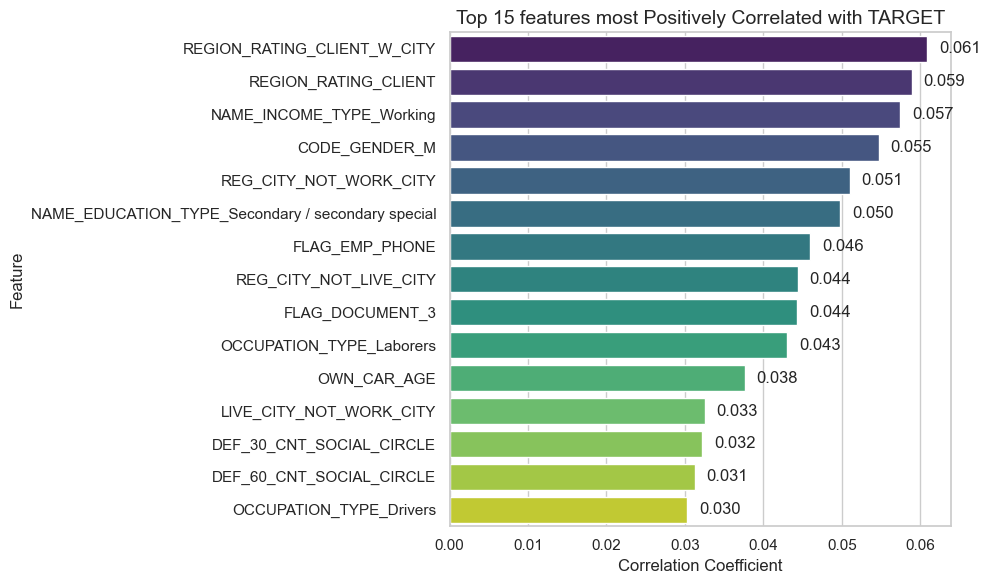

In [66]:
# Select the last 15 top positive correlated features
top_corr = correlations[-16:-1].sort_values(ascending=False) # Remove 'TARGET'

# Set style
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")

# Add value labels
for i, v in enumerate(top_corr.values):
    ax.text(v + 0.0015, i, f"{v:.3f}", va='center', fontweight='light')

plt.title("Top 15 features most Positively Correlated with TARGET", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

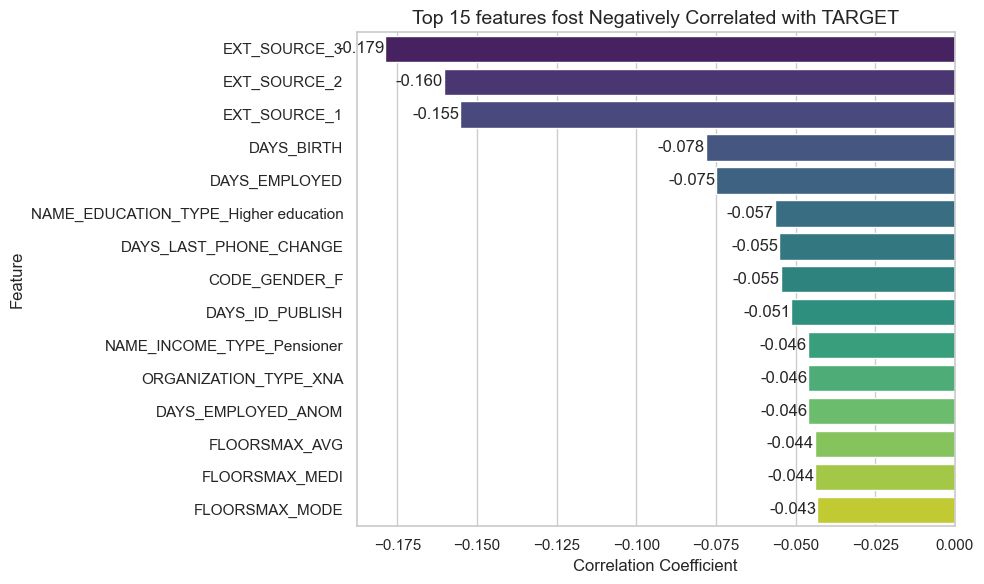

In [67]:
# Select the last 15 top negative correlated features
top_corr = correlations.head(15).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")

# Add value labels
for i, v in enumerate(top_corr.values):
    ax.text(v - 0.015, i, f"{v:.3f}", va='center', fontweight='light')

plt.title("Top 15 features fost Negatively Correlated with TARGET", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [68]:
# Define some of the main features
feature_definition('EXT_SOURCE_3')
print()
feature_definition('DAYS_ID_PUBLISH')
print()
feature_definition('REGION_RATING_CLIENT_W_CITY')
print()
feature_definition('REGION_RATING_CLIENT')

Definition of feature "EXT_SOURCE_3" : Normalized score from external data source

Definition of feature "DAYS_ID_PUBLISH" : How many days before the application did client change the identity document with which he applied for the loan

Definition of feature "REGION_RATING_CLIENT_W_CITY" : Our rating of the region where client lives with taking city into account (1,2,3)

Definition of feature "REGION_RATING_CLIENT" : Our rating of the region where client lives (1,2,3)


Correlation analysis :

 - Customers with ``higher EXT_SOURCES`` (credit rating calculated from external data) are more likely to repay their loan.

 - ``Older customers`` and ``older employees`` are more likely to repay their loans.

 - Males are less likely to repay their loan, than ``females``.

 - Customer with ``higher education`` are more likely to repay their loan, than customer with secondaty education.

 - ``Pensioners`` customer are more likely to repay their loan than workers.

 - The higher the ``Region rating`` is, the less likely customers repay their loan.

In [70]:
# Store most correlated features in a list for future use
nb_feat = 50
key_feature_list = np.abs(correlations).sort_values(ascending=False)[1:nb_feat+1]

### Effect of Age on Repayment

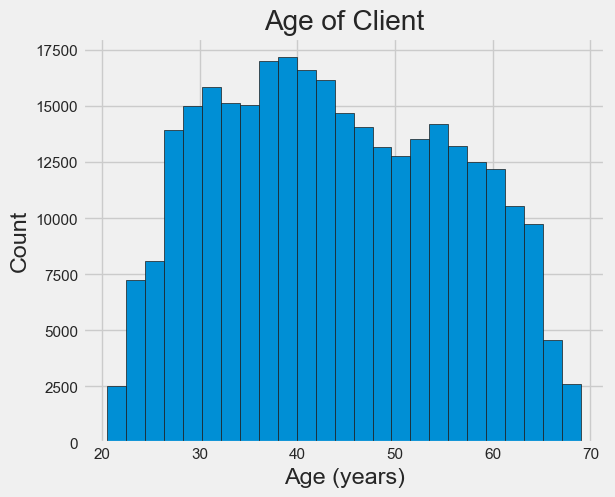

In [72]:
# Set the style of plots
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6, 5))

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365.25, edgecolor = 'k', bins = 25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

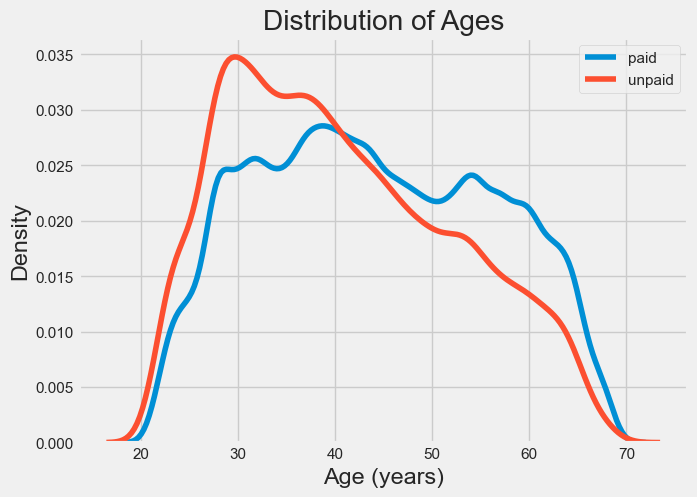

In [73]:
# Display distribution
plt.figure(figsize = (7, 5))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365.25, label = 'paid')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365.25, label = 'unpaid')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()
plt.show()

ccl : Since the curves intersect at an approximate pivot age of 40 years, this indicates that younger clients are obviously less likely to repay their loans compared to older clients.

### Effect of Exterior Sources

In [76]:
feature_definition('EXT_SOURCE_1')

Definition of feature "EXT_SOURCE_1" : Normalized score from external data source


In [77]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

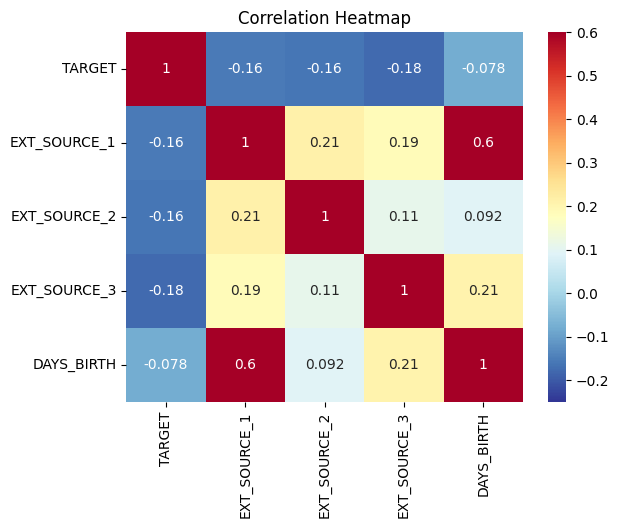

In [78]:
# Heatmap of correlations
plt.style.use('default')
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

ccl : All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

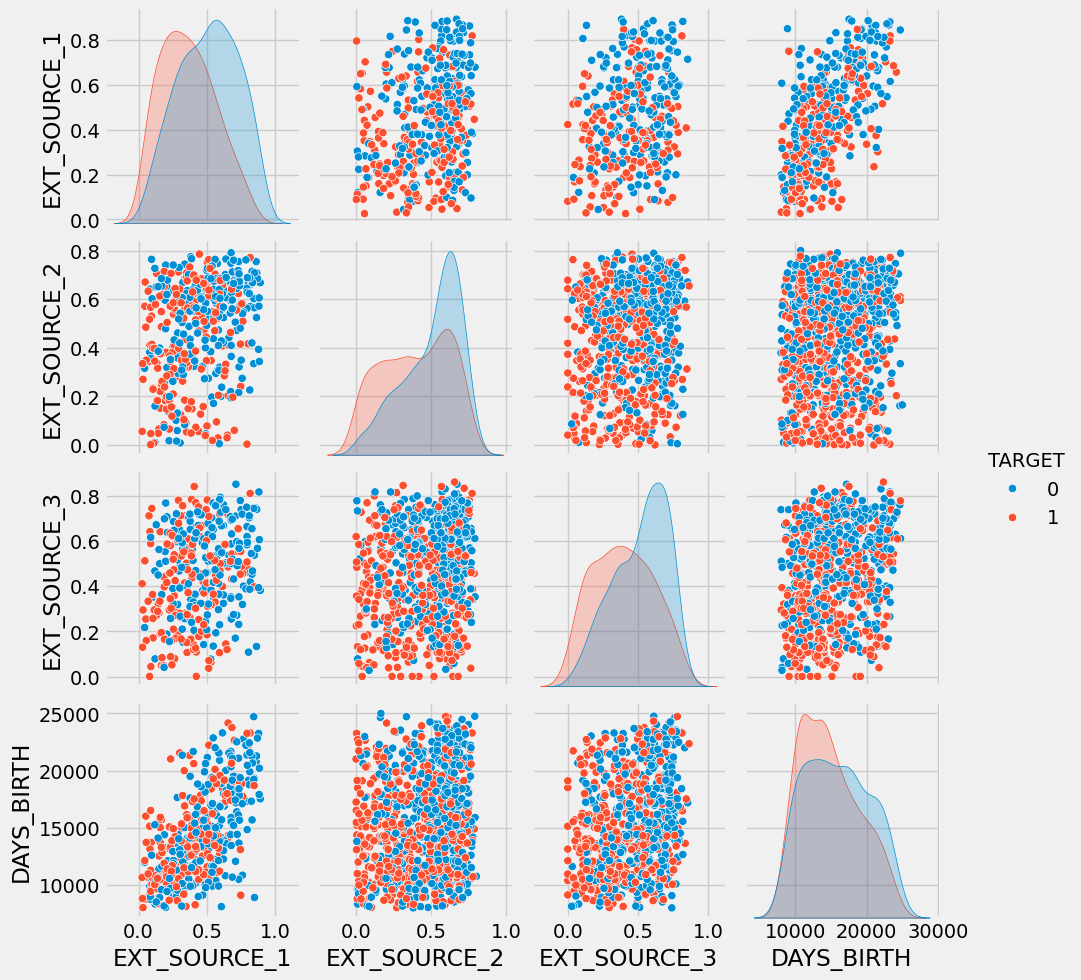

In [80]:
# Pairplot dsiaply with rebalanced categories
plt.style.use('fivethirtyeight')
n_samples = 500 # determined to data to display for both categories

# Separate the data into two subsets based on the TARGET values
repaid = app_train[app_train['TARGET'] == 0]
not_repaid = app_train[app_train['TARGET'] == 1]

# Sample an equal number of instances from each subset
repaid_sample = repaid.sample(n_samples, random_state=42)
not_repaid_sample = not_repaid.sample(n_samples, random_state=42)

# Combine the sampled data back into a single DataFrame
balanced_data = pd.concat([repaid_sample, not_repaid_sample])
# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Create a pairplot with the balanced data
sns.pairplot(data=balanced_data, vars=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'], hue='TARGET')
plt.show()

ccl : We can see that the distribution of the target is not uniform. The target value of 1 appears to be more heavily concentrated on the left side of the graphs. "EXT_SOURCE_1" is also strongly positively correlated with the client's age.

### Effect of Gender

In [83]:
# Feature analysis vs target
gender_stats = app_train.groupby('CODE_GENDER_M')['TARGET'].agg(['count', 'mean', 'std'])
gender_stats['gender'] = ['Female', 'Male']
gender_stats

count      mean       std  gender
CODE_GENDER_M                                    
False          202452  0.069992  0.255134  Female
True           105059  0.101419  0.301884    Male

Let's analyse the independance of these 2 sets regarding Chi² test.

In [85]:
# Create a contingency table
contingency_table = pd.crosstab(app_train['CODE_GENDER_M'], app_train['TARGET'])
print(contingency_table, '\n')

# Perform Chi-Square test
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f'Chi-Square Statistic: {chi2:.2f}')
print(f'P-Value: {p:.3f}')

TARGET              0      1
CODE_GENDER_M               
False          188282  14170
True            94404  10655 

Chi-Square Statistic: 920.10
P-Value: 0.000


Chi-Square Test: Tests the null hypothesis that the two variables are independent. A low p-value (typically < 0.05) indicates a significant association.

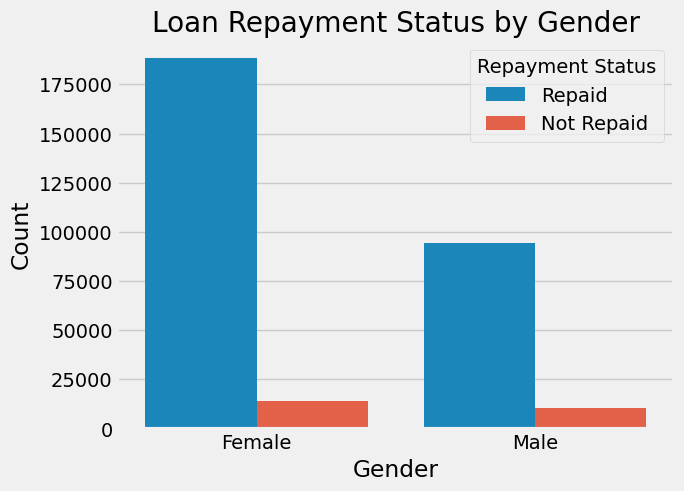

In [87]:
# Display gender vs target barplot
ax = sns.countplot(x='CODE_GENDER_M', hue='TARGET', data=app_train)
plt.title('Loan Repayment Status by Gender')
ax.set_xticklabels(['Female', 'Male'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Repayment Status', labels=['Repaid', 'Not Repaid'])
plt.show()

ccl : 
Based on the Chi-Square test results, we can conclude that there is a significant association between gender and loan repayment status in the dataset. This suggests that gender may be an important factor in predicting whether a customer will repay their loan.

### Effect on Income Type

In [90]:
# 'NAME_INCOME_TYPE' categories
app_train_master['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

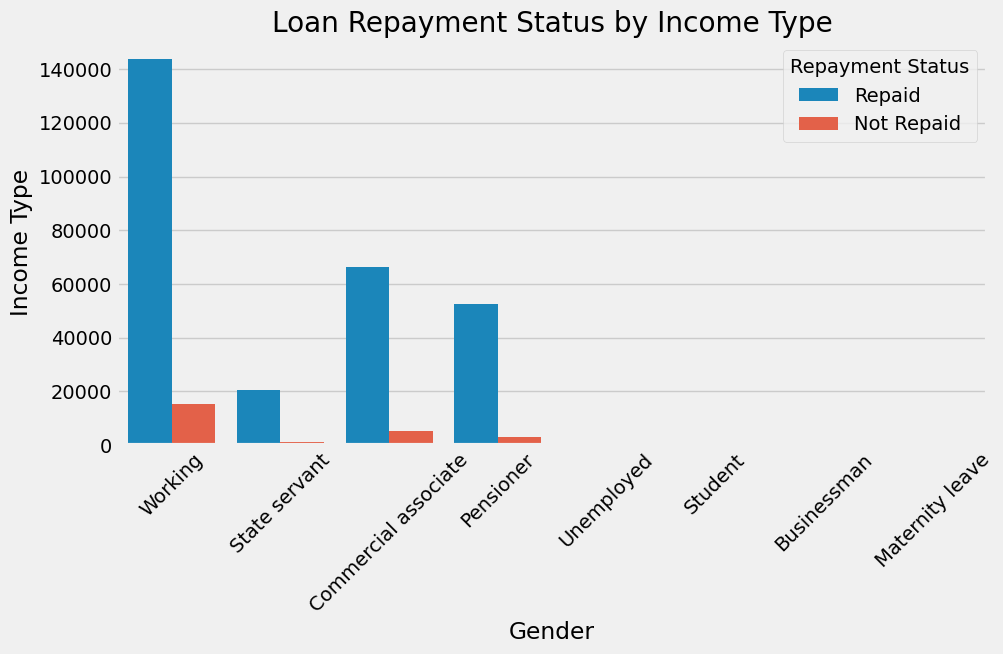

In [91]:
# Display the feature vs target in a barplot
plt.figure(figsize=(10,5))
ax = sns.countplot(x='NAME_INCOME_TYPE', hue='TARGET', data=app_train_master)
plt.title('Loan Repayment Status by Income Type')
ax.set_xticklabels(app_train_master['NAME_INCOME_TYPE'].unique())
plt.xlabel('Gender')
plt.ylabel('Income Type')
plt.legend(title='Repayment Status', labels=['Repaid', 'Not Repaid'])
plt.xticks(rotation=45)
plt.show()

In [92]:
# Cross-tabulation of Income Type and Loan Repayment Default
app_train_master.pivot_table(
    index='NAME_INCOME_TYPE',
    columns='TARGET',
    aggfunc='size',
    fill_value=0
)

TARGET                     0      1
NAME_INCOME_TYPE                   
Businessman               10      0
Commercial associate   66257   5360
Maternity leave            3      2
Pensioner              52380   2982
State servant          20454   1249
Student                   18      0
Unemployed                14      8
Working               143550  15224

In [93]:
# Loan default rate by income type
print("Loan default rate")
app_train_master.groupby('NAME_INCOME_TYPE')['TARGET'].mean().sort_values()

Loan default rate


NAME_INCOME_TYPE
Businessman             0.000000
Student                 0.000000
Pensioner               0.053864
State servant           0.057550
Commercial associate    0.074843
Working                 0.095885
Unemployed              0.363636
Maternity leave         0.400000
Name: TARGET, dtype: float64

ccl : There is clear difference between the income type and a loan repayment default.

### Effect on Region Rating

In [96]:
# Features definition
feature_definition('REGION_RATING_CLIENT')
feature_definition('REGION_RATING_CLIENT_W_CITY')

Definition of feature "REGION_RATING_CLIENT" : Our rating of the region where client lives (1,2,3)
Definition of feature "REGION_RATING_CLIENT_W_CITY" : Our rating of the region where client lives with taking city into account (1,2,3)


In [97]:
app_train['REGION_RATING_CLIENT'].value_counts()

REGION_RATING_CLIENT
2    226984
3     48330
1     32197
Name: count, dtype: int64

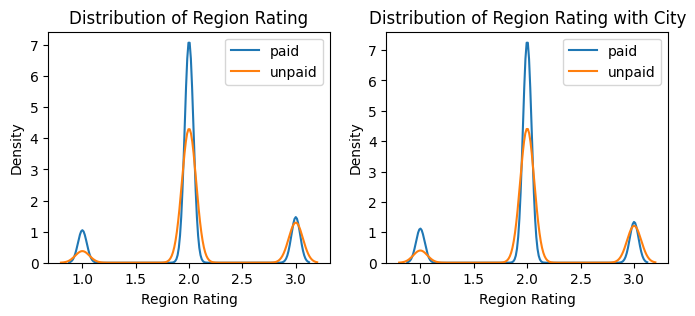

In [98]:
# Display features distribution vs target
plt.style.use('default')
plt.figure(figsize = (8,3))

plt.subplot(1, 2, 1)
# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'REGION_RATING_CLIENT'], label = 'paid')
# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'REGION_RATING_CLIENT'], label = 'unpaid')
plt.xlabel('Region Rating')
plt.ylabel('Density')
plt.title('Distribution of Region Rating')
plt.legend()

plt.subplot(1, 2, 2)
# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'REGION_RATING_CLIENT_W_CITY'], label = 'paid')
# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'REGION_RATING_CLIENT_W_CITY'], label = 'unpaid')
plt.xlabel('Region Rating')
plt.ylabel('Density')
plt.title('Distribution of Region Rating with City')
plt.legend()

plt.show()

ccl : The graph clearly display a positive correlation, meaning the higher the region rate, the higher the risk of loan default.

# MLFlow initialization

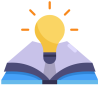

MLflow is an open-source platform designed to manage machine learning projects, including experimentation, reproducibility, and deployment. It helps data scientists and engineers track experiments, package code into reusable components, and share and deploy models efficiently.

Execute the command in Anaconda command prompt to run the MLFlow server on a local machine :

mlflow server --host 127.0.0.1 --port 5000

In [103]:
# Connect to the mlflow local server
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [104]:
# Create a new MLflow Experiment
mlflow.set_experiment("OC_project7_loan_scoring")

<Experiment: artifact_location='mlflow-artifacts:/627297881201483859', creation_time=1744383234541, experiment_id='627297881201483859', last_update_time=1744383234541, lifecycle_stage='active', name='OC_project7_loan_scoring', tags={}>

# Baseline

## LogisticRegression (classification)

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling).

In [108]:
# Prepare data
X = app_train.drop(columns=['TARGET'])
y = app_train['TARGET']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [109]:
X_train.shape

(230633, 243)

Let's define a pipeline to avoid data leakage in the cross validation process.

In [111]:
# Define preprocessing pipeline
preprocess_p = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

In [112]:
# Define the model and hyperparameters
C_value = 0.1
log_reg = LogisticRegression(C=C_value)

# Combine preprocessing with logistic regression model
pipeline = make_pipeline(preprocess_p, log_reg)

# Perform cross-validation
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring='roc_auc', verbose=3, return_train_score=True)

with mlflow.start_run(run_name="Baseline") as run:    
    
    # Train on the training data
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)    

    # Log parameters
    mlflow.log_param("C", C_value)

    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)    

    # Log model
    mlflow.sklearn.log_model(log_reg, "logistic_regression_model")

    # Store the run ID in a variable
    run_id = run.info.run_id

[CV] END ..................., score=(train=0.745, test=0.743) total time=   8.3s
[CV] END ..................., score=(train=0.745, test=0.740) total time=   6.8s
[CV] END ..................., score=(train=0.747, test=0.738) total time=   8.0s
[CV] END ..................., score=(train=0.745, test=0.746) total time=   8.2s
[CV] END ..................., score=(train=0.745, test=0.745) total time=   7.6s


2025/04/20 14:51:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Baseline at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/c7a1eab751654b7494b789b42dd80dd3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859


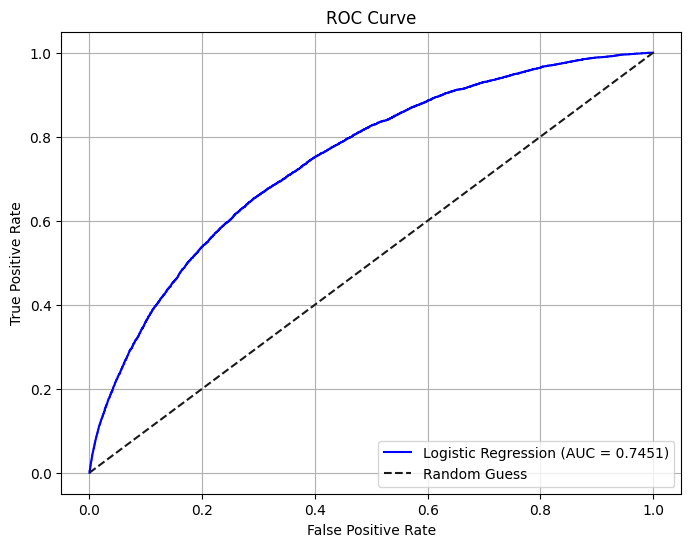

In [113]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [114]:
# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}')
print(f'Test Balanced Accuracy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))

Train Accuracy: 0.919
Test Accuracy: 0.919
Test Balanced Accuracy: 0.504

Confusion Matrix:
 [[70609    78]
 [ 6132    59]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     70687
           1       0.43      0.01      0.02      6191

    accuracy                           0.92     76878
   macro avg       0.68      0.50      0.49     76878
weighted avg       0.88      0.92      0.88     76878



## Defining a custom metric

We are going to develop a custom metric based on Recall and Specificity.

Recall measures the model's ability to correctly identify positive instances, i.e., unpaid loans.

Specificity measures the model's ability to correctly identify negative instances, i.e., paid loans.

For the company "Prêt à dépenser," the primary goal is to ``avoid customers who will not be able to repay their loans``. This means that Recall is the key metric. The primary goal of the company is to avoid customers who won't be able to repay their loans, indeed. High Recall ensures that the model correctly identifies as many defaulted loans as possible, which is essential for managing financial risk.

On the contrary, missing out on customers who will repay their loans is undesirable but not catastrophic.

The custom metric combines Recall and Specificity but gives more weight to Recall. Recall weight and Specificty weight can be adjsuted according to business risk management decision. The custom loan score is between 0 and 1, where 0 is extremely bad and 1 is perfect.

In [117]:
def custom_credit_metric(y_test, y_test_pred):
    """
    Function that calculates a custom metric for loan impayment risk management
    input : y_test, y_test_predicted
    output : custom score [0;1]
    """
    
    # Adjust Recall and Specificity weight
    recall_weight = 10
    specificity_weight = 1
    
    # Calculate Specificity and Recall    
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    specificity = tn / (tn + fp)
    recall = tp / (tp + fn)

    # Calculate custom loan score
    loan_score = (specificity_weight * specificity + recall_weight * recall) / (specificity_weight + recall_weight)

    return loan_score

In [118]:
# Create a scorer from the previous function to be used in CV and GridSearchCV
custom_scorer = make_scorer(custom_credit_metric, greater_is_better=True)

In [119]:
loan_score = custom_credit_metric(y_test, y_test_pred)
print(f'The custom credit score is : {loan_score:.3f}')

The custom credit score is : 0.099


In [120]:
# Use the stored run ID to log the custom metric
with mlflow.start_run(run_id=run_id):
    mlflow.log_metric("Custom Loan Score", loan_score)

🏃 View run Baseline at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/c7a1eab751654b7494b789b42dd80dd3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859


ccl : The model is not good. Accuracy is not the best metric when dealing with imbalanced classes.

Confusion Matrix :
FN = 6132 ! The model is failing to catch a lot of unpaid loans, which is critical in this case

Recall for class 1 = 0.01 : Recall is the proportion of actual unpaid loans that were correctly identified. Here, it's only 1%, meaning the model is missing 99% of the unpaid loans (false negatives). This is a huge problem in this scenario because unpaid loans represent a significant risk for the bank.

In [122]:
# Analyse feature importance
feature_names = X.columns.tolist()

# Access the fitted logistic regression step
log_reg_model = pipeline.named_steps['logisticregression']
coefficients = log_reg_model.coef_[0]

# Create a DataFrame to associate feature names with their coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients
coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Print the DataFrame to see the key features
coef_df.head(10)

Feature  Coefficient  Absolute_Coefficient
33              EXT_SOURCE_3    -2.360955              2.360955
32              EXT_SOURCE_2    -1.729711              1.729711
7                AMT_ANNUITY     1.288499              1.288499
31              EXT_SOURCE_1    -1.083282              1.083282
8            AMT_GOODS_PRICE    -1.077220              1.077220
11             DAYS_EMPLOYED    -1.071577              1.071577
80  DEF_60_CNT_SOCIAL_CIRCLE     0.929517              0.929517
78  DEF_30_CNT_SOCIAL_CIRCLE     0.845070              0.845070
6                 AMT_CREDIT     0.584974              0.584974
93          FLAG_DOCUMENT_13    -0.552183              0.552183

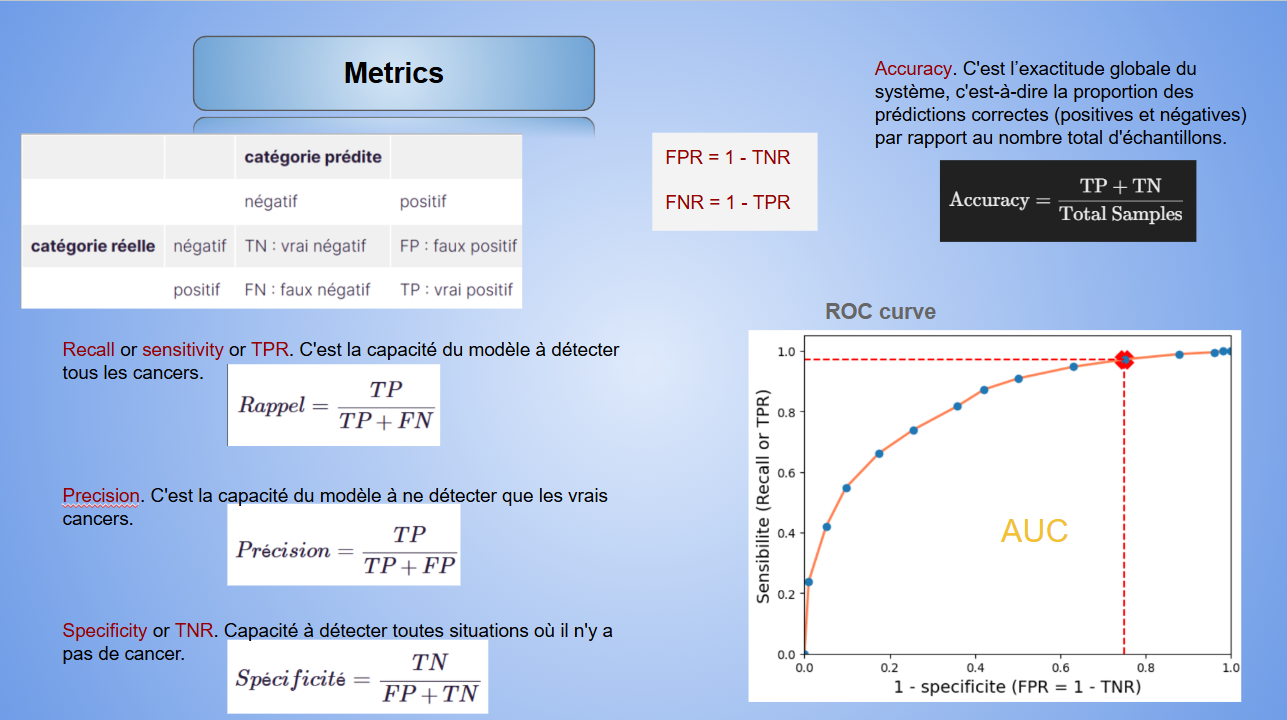

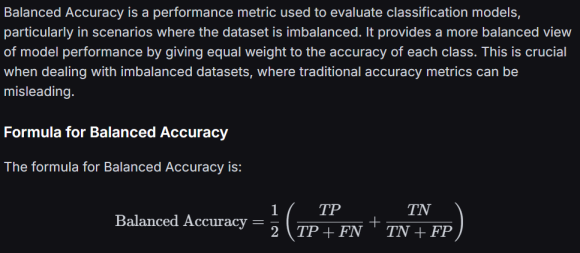

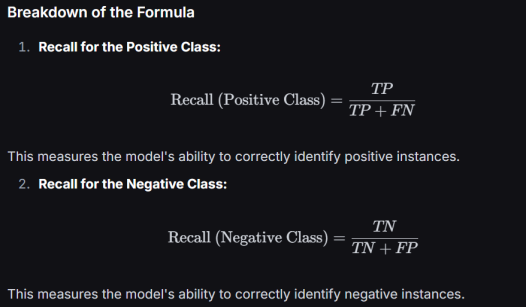

## Lower the threshold

The default threshold for logistic regression is typically set at 0.5. However, using different thresholds can result in different performance metrics compromise. Let's explore how varying thresholds affect the ROC-AUC curve.

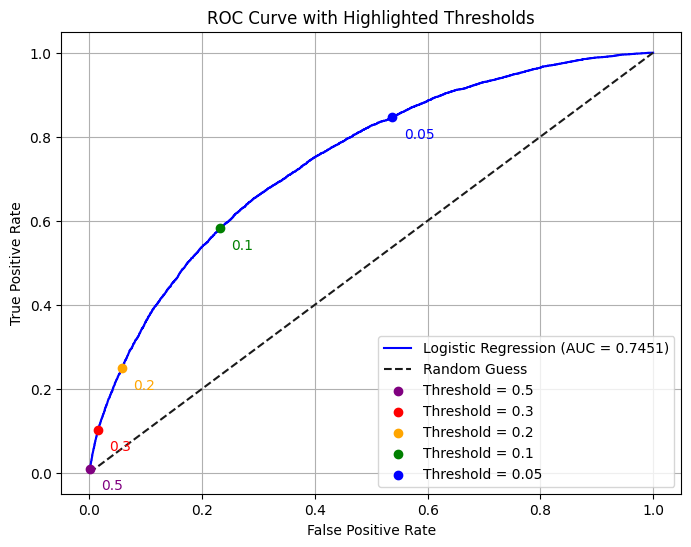

In [127]:
# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Thresholds to highlight
highlight_thresholds = [0.5, 0.3, 0.2, 0.1, 0.05]
colors = ['purple', 'red', 'orange', 'green', 'blue']

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Plot each threshold
for thresh, color in zip(highlight_thresholds, colors):
    idx = np.argmin(np.abs(thresholds - thresh))
    plt.scatter(fpr[idx], tpr[idx], color=color, label=f'Threshold = {thresh}', zorder=10)
    plt.text(fpr[idx] + 0.02, tpr[idx] - 0.05, f'{thresh}', color=color)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Highlighted Thresholds')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Let's fix TPR = 0.95 and determine the corresponding threshold. Then we'll calculate the metrics to compare with inital threshold = 0.5.

In [129]:
# Find index where TPR est near 0.95
target_tpr = 0.95
idx = np.argmin(np.abs(tpr - target_tpr))

# Get correspondiong threshold
best_threshold = thresholds[idx]
actual_tpr = tpr[idx]
actual_fpr = fpr[idx]

print(f"Approx threshold for TPR = 0.95 : {best_threshold:.4f}")
print(f"TPR recalculated : {actual_tpr:.4f}")
print(f"FPR recalculated : {actual_fpr:.4f}")

Approx threshold for TPR = 0.95 : 0.0305
TPR recalculated : 0.9499
FPR recalculated : 0.7580


In [130]:
# Prediction with new threshold
y_pred_95 = (y_prob >= best_threshold).astype(int)

# Evaluate the model
test_acc = accuracy_score(y_test, y_pred_95)
balanced_acc = balanced_accuracy_score(y_test, y_pred_95)    

print(f'Test Accuracy: {test_acc:.3f}')
print(f'Test Balanced Accuracy: {balanced_acc:.3f}')

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_95))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_95))

custom_loan_score = custom_credit_metric(y_test, y_pred_95)
print(f'The custom credit score is : {custom_loan_score:.3f}')

Test Accuracy: 0.299
Test Balanced Accuracy: 0.596

Confusion Matrix:
[[17103 53584]
 [  310  5881]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.24      0.39     70687
           1       0.10      0.95      0.18      6191

    accuracy                           0.30     76878
   macro avg       0.54      0.60      0.28     76878
weighted avg       0.91      0.30      0.37     76878

The custom credit score is : 0.886


ccl : The number of FN has been drastically reduced, from 6132 to 310. That's the reason why the custom credit score is much higher. However, the number of FP is still alarmingly high, with 53584 customers potentially being denied loans despite their ability to repay them correctly !

summary : We have built a baseline model using a custom credit score metric. We found that lowering the logistic regression threshold can improve this custom credit score. However, the downside is that too many customers are being refused loans. Next, we will explore different options to improve the model's performance.

# Balance class_weight

Scikit-learn Logistic Regression model can handle imbalanced classes, using the class_weight hyperparameter.

In [135]:
# Define the model and hyperparameters ; set class_weight to 'balanced'
C_value = 0.1
log_reg = LogisticRegression(C=C_value, class_weight='balanced')

# Combine preprocessing with logistic regression model
pipeline = make_pipeline(preprocess_p, log_reg)

# Perform cross-validation
scoring = {'roc_auc': 'roc_auc',
           'balanced_accuracy': 'balanced_accuracy',
           'recall': 'recall'}
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring, verbose=3, return_train_score=True)

with mlflow.start_run(run_name="Logistic Regression balanced classes"):    
    
    # Train on the training data
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    custom_loan_score = custom_credit_metric(y_test, y_test_pred) # custom metric    

    # Log parameters
    mlflow.log_param("C", C_value)

    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Custom Loan Score", custom_loan_score)

    # Log model
    mlflow.sklearn.log_model(log_reg, "logistic_regression_model")

[CV] END  balanced_accuracy: (train=0.682, test=0.680) recall: (train=0.676, test=0.673) roc_auc: (train=0.747, test=0.744) total time=  10.0s
[CV] END  balanced_accuracy: (train=0.683, test=0.678) recall: (train=0.678, test=0.670) roc_auc: (train=0.748, test=0.742) total time=   9.3s
[CV] END  balanced_accuracy: (train=0.685, test=0.675) recall: (train=0.680, test=0.661) roc_auc: (train=0.749, test=0.739) total time=   9.1s
[CV] END  balanced_accuracy: (train=0.682, test=0.685) recall: (train=0.674, test=0.682) roc_auc: (train=0.747, test=0.747) total time=   9.1s
[CV] END  balanced_accuracy: (train=0.682, test=0.682) recall: (train=0.677, test=0.676) roc_auc: (train=0.747, test=0.746) total time=   9.6s


2025/04/20 14:53:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression balanced classes at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/6893220994184aeda5f68ab9fd71c011
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859


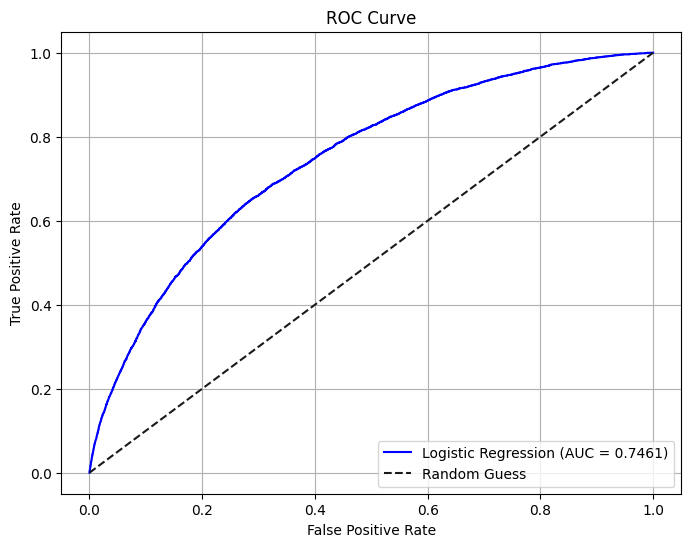

Train Accuracy: 0.687
Test Accuracy: 0.685

Test Balanced Accuraccy: 0.681

Confusion Matrix:
 [[48497 22190]
 [ 2011  4180]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     70687
           1       0.16      0.68      0.26      6191

    accuracy                           0.69     76878
   macro avg       0.56      0.68      0.53     76878
weighted avg       0.90      0.69      0.76     76878

The custom credit score is : 0.676


In [136]:
# Evaluate the model

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}\n')
print(f'Test Balanced Accuraccy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))
print(f'The custom credit score is : {custom_loan_score:.3f}')

In [137]:
# Analyse feature importance
feature_names = X.columns.tolist()

# Access the fitted logistic regression step
log_reg_model = pipeline.named_steps['logisticregression']
coefficients = log_reg_model.coef_[0]

# Create a DataFrame to associate feature names with their coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients
coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Print the DataFrame to see the key features
coef_df.head(10)

Feature  Coefficient  Absolute_Coefficient
8                AMT_GOODS_PRICE    -2.501990              2.501990
33                  EXT_SOURCE_3    -2.429015              2.429015
80      DEF_60_CNT_SOCIAL_CIRCLE     2.151955              2.151955
78      DEF_30_CNT_SOCIAL_CIRCLE     1.931401              1.931401
7                    AMT_ANNUITY     1.847274              1.847274
6                     AMT_CREDIT     1.777517              1.777517
32                  EXT_SOURCE_2    -1.730100              1.730100
31                  EXT_SOURCE_1    -1.188702              1.188702
11                 DAYS_EMPLOYED    -1.156390              1.156390
124  NAME_INCOME_TYPE_Unemployed     0.797738              0.797738

ccl : Balancing the classes in Logistic Regression helps a lot. The recall for class 1 has been significantly improved from 0.01 (Baseline) to 0.68. Now, only 2011 loans are incorrectly considered unpaid, instead of 6132 in the Baseline model. This has led to a substantial improvement in the custom credit score. It is intersting to note that the key features have changed. The financial features have taken over from external ressources features.

# Model with enriched features

We will try to enrich the model by improving the features through feature engineering.

## Feature Engineering

We create polynomial features using the EXT_SOURCE variables and the DAYS_BIRTH variable.

In [143]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
imputer = SimpleImputer(strategy = 'median')
poly_features = imputer.fit_transform(poly_features)
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [144]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [145]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2', 'EXT_SOURCE_1^3',
       'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3',
       'EXT_SOURCE_1^2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_2^2',
       'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
       'EXT_SOURCE_1 EXT_SOURCE_3^2',
       'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
       'EXT_SOURCE_1 DAYS_BIRTH^2', 'EXT_SOURCE_2^3',
       'EXT_SOURCE_2^2 EXT_SOURCE_3', 'EXT_SOURCE_2^2 DAYS_BIRTH',
       'EXT_SOURCE_2 EXT_SOURCE_3^2',
       'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
       'EXT_SOURCE_2 DAYS_BIRTH^2', 'EXT_SOURCE_3^3',
       'EXT_SOURCE_3^2 DAYS_BIRTH', 'EXT_SOURCE_3 DAYS_BIR

In [146]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_feature_w_target = poly_features.copy()
poly_feature_w_target['TARGET'] = app_train['TARGET']

# Find the correlations with the target
poly_corrs = poly_feature_w_target.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print()
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64

DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


ccl : We can see a better correlation than previously.

In [148]:
# Merge polynomial features into training dataframe
poly_features.drop(columns='DAYS_BIRTH', inplace=True)
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_enriched = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

app_train_enriched.shape

(307511, 278)

Domain Knowledge Features : We now create new features based on business expertise.

CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income

ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income

CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due

DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [151]:
app_train_enriched['CREDIT_INCOME_PERCENT'] = app_train_enriched['AMT_CREDIT'] / app_train_enriched['AMT_INCOME_TOTAL']
app_train_enriched['ANNUITY_INCOME_PERCENT'] = app_train_enriched['AMT_ANNUITY'] / app_train_enriched['AMT_INCOME_TOTAL']
app_train_enriched['CREDIT_TERM'] = app_train_enriched['AMT_ANNUITY'] / app_train_enriched['AMT_CREDIT']
app_train_enriched['DAYS_EMPLOYED_PERCENT'] = app_train_enriched['DAYS_EMPLOYED'] / app_train_enriched['DAYS_BIRTH']
app_train_enriched.shape

(307511, 282)

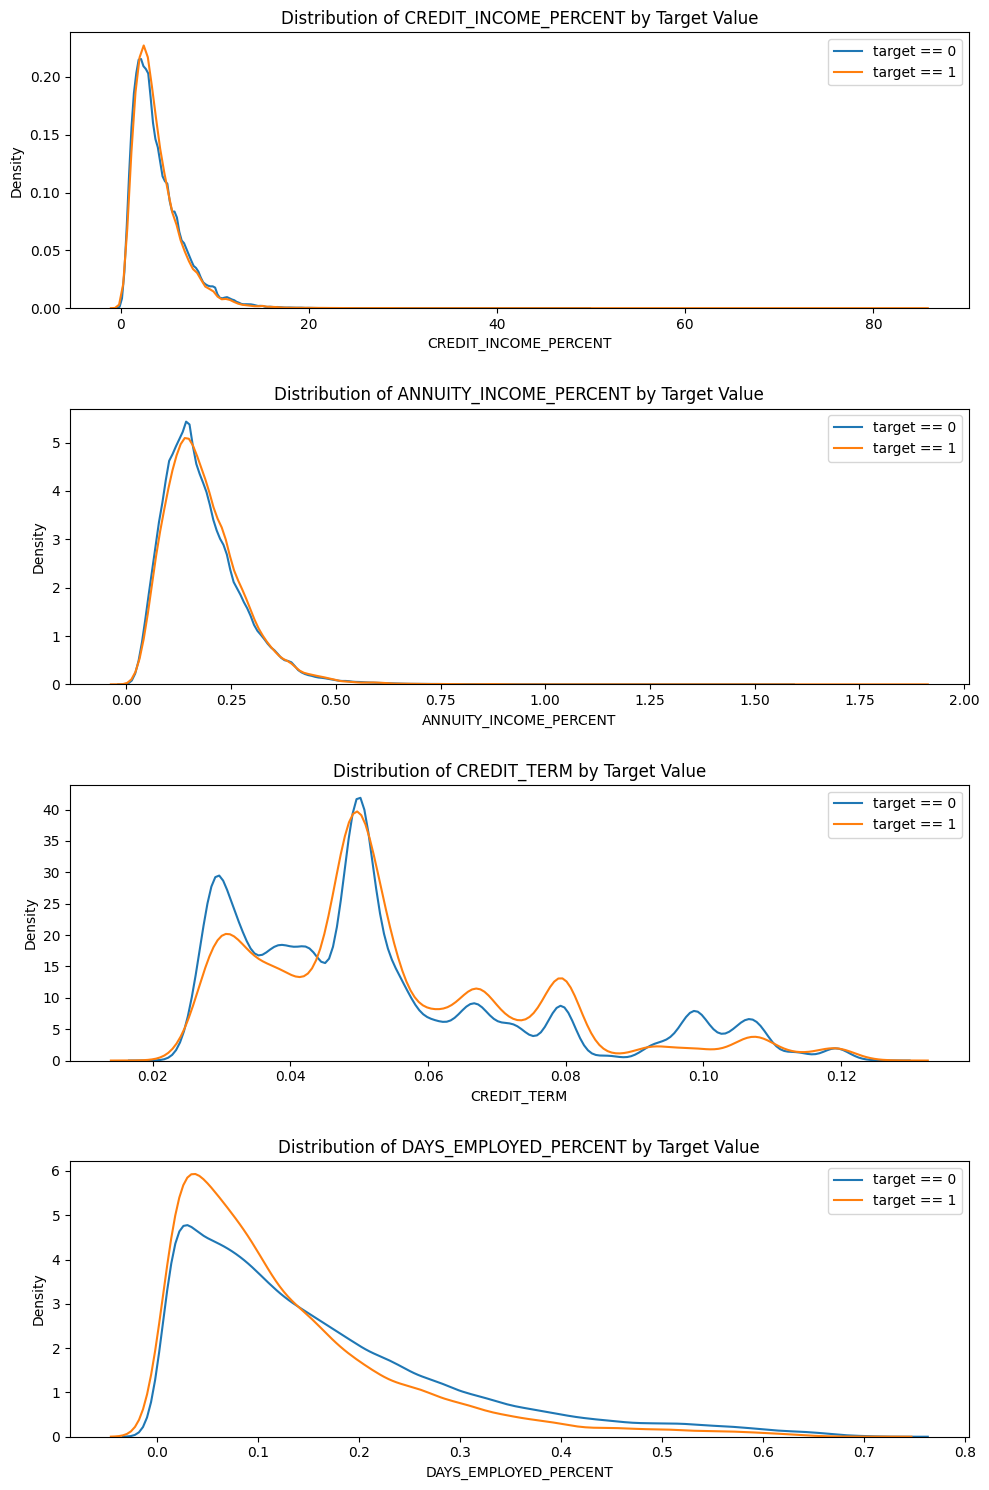

In [152]:
plt.figure(figsize = (10, 15))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_enriched.loc[app_train_enriched['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_enriched.loc[app_train_enriched['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

ccl : The analysis of the graphs above shows us that the distribution of the 4 new domain features created differs depending on the traget value, which main improve the model performance.

## Logistic Regression with Feature Engineering

In [155]:
# Prepare data
X = app_train_enriched.drop(columns=['TARGET'])
y = app_train_enriched['TARGET']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [156]:
X_train.shape

(230633, 281)

In [157]:
# Define preprocessing pipeline
preprocess_p = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

In [158]:
# Define the model and hyperparameters
C_value = 0.1
log_reg = LogisticRegression(C=C_value, class_weight='balanced')

# Combine preprocessing with logistic regression model
pipeline = make_pipeline(preprocess_p, log_reg)

# Perform cross-validation
scoring = {'roc_auc': 'roc_auc',
           'balanced_accuracy': 'balanced_accuracy',
           'recall': 'recall'}
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring, verbose=3, return_train_score=True)

with mlflow.start_run(run_name="Logistic Regression balanced feat eng"):    
    
    # Train on the training data
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    custom_loan_score = custom_credit_metric(y_test, y_test_pred) # custom metric    

    # Log parameters
    mlflow.log_param("C", C_value)

    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Custom Loan Score", custom_loan_score)

    # Log model
    mlflow.sklearn.log_model(log_reg, "logistic_regression_model")

[CV] END  balanced_accuracy: (train=0.684, test=0.681) recall: (train=0.683, test=0.679) roc_auc: (train=0.750, test=0.747) total time=  11.2s
[CV] END  balanced_accuracy: (train=0.684, test=0.680) recall: (train=0.683, test=0.676) roc_auc: (train=0.750, test=0.744) total time=  11.9s
[CV] END  balanced_accuracy: (train=0.686, test=0.677) recall: (train=0.686, test=0.668) roc_auc: (train=0.751, test=0.741) total time=  12.2s
[CV] END  balanced_accuracy: (train=0.683, test=0.687) recall: (train=0.680, test=0.690) roc_auc: (train=0.749, test=0.750) total time=  12.4s
[CV] END  balanced_accuracy: (train=0.683, test=0.681) recall: (train=0.681, test=0.675) roc_auc: (train=0.750, test=0.748) total time=  12.2s


2025/04/20 14:54:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression balanced feat eng at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/8256d27581ea42c7a1a9904ecdb0fdc0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859


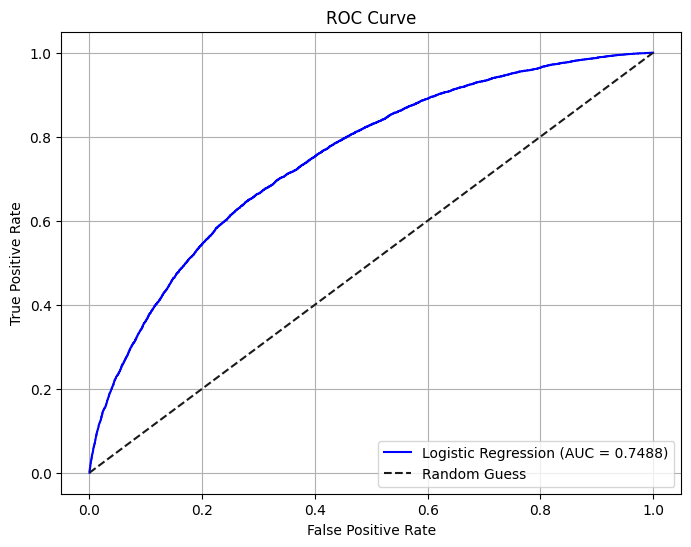

Train Accuracy: 0.684
Test Accuracy: 0.682

Test Balanced Accuraccy: 0.681

Confusion Matrix:
 [[48190 22497]
 [ 1976  4215]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.68      0.80     70687
           1       0.16      0.68      0.26      6191

    accuracy                           0.68     76878
   macro avg       0.56      0.68      0.53     76878
weighted avg       0.90      0.68      0.75     76878

The custom credit score is : 0.681


In [159]:
# Evaluate the model

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}\n')
print(f'Test Balanced Accuraccy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))
print(f'The custom credit score is : {custom_loan_score:.3f}')

In [160]:
# Analyse feature importance
feature_names = X.columns.tolist()

# Access the fitted logistic regression step
log_reg_model = pipeline.named_steps['logisticregression']
coefficients = log_reg_model.coef_[0]

# Create a DataFrame to associate feature names with their coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients
coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Print the DataFrame to see the key features
coef_df.head(10)

Feature  Coefficient  Absolute_Coefficient
7                  AMT_ANNUITY     2.494649              2.494649
8              AMT_GOODS_PRICE    -2.436208              2.436208
80    DEF_60_CNT_SOCIAL_CIRCLE     1.737929              1.737929
278     ANNUITY_INCOME_PERCENT     1.648104              1.648104
78    DEF_30_CNT_SOCIAL_CIRCLE     1.533950              1.533950
10                  DAYS_BIRTH     1.145663              1.145663
246             EXT_SOURCE_3_y    -0.954602              0.954602
252  EXT_SOURCE_2 EXT_SOURCE_3    -0.846523              0.846523
33              EXT_SOURCE_3_x    -0.820314              0.820314
93            FLAG_DOCUMENT_13    -0.785311              0.785311

ccl : Once again the Cross Validation shows there is no overfitting. There is a very slight improvement in performance by adding the data created using feature engineering. Several feature engineering features appear in the most important feature list.

We are now going to try different models and compare them with our baseline and improved Logistic Regression model. First we'll try a bagging model (Random Forest), then different boosting models (Adaboost, Gradientboosting, XGBoost and LightGBM).

# Random Forest

A random Forest may be an intersting model because of its architecture using decision trees that allows to find non-linear and complex interactions between features.

In [1329]:
# Define the model and hyperparameters
n_estimators = 100
rf_model = RandomForestClassifier(n_estimators=n_estimators, class_weight='balanced', random_state=42, n_jobs=-1)

# Combine preprocessing with RAndom Forest model
pipeline = make_pipeline(preprocess_p, rf_model)

# Perform cross-validation
scoring = {'roc_auc': 'roc_auc',
           'balanced_accuracy': 'balanced_accuracy',
           'recall': 'recall'}
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring, verbose=3, return_train_score=True)

with mlflow.start_run(run_name="Random Forest"):    
    
    # Train on the training data
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    custom_loan_score = custom_credit_metric(y_test, y_test_pred) # custom metric    

    # Log parameters
    mlflow.log_param("n_estimators", n_estimators)

    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Custom Loan Score", custom_loan_score)

    # Log model
    mlflow.sklearn.log_model(rf_model, "random_forest_model")

[CV] END  balanced_accuracy: (train=1.000, test=0.507) recall: (train=1.000, test=0.015) roc_auc: (train=1.000, test=0.721) total time= 2.0min
[CV] END  balanced_accuracy: (train=1.000, test=0.508) recall: (train=1.000, test=0.016) roc_auc: (train=1.000, test=0.720) total time= 2.0min
[CV] END  balanced_accuracy: (train=1.000, test=0.507) recall: (train=1.000, test=0.014) roc_auc: (train=1.000, test=0.721) total time= 1.9min
[CV] END  balanced_accuracy: (train=1.000, test=0.505) recall: (train=0.999, test=0.012) roc_auc: (train=1.000, test=0.716) total time= 1.9min
[CV] END  balanced_accuracy: (train=1.000, test=0.505) recall: (train=0.999, test=0.012) roc_auc: (train=1.000, test=0.718) total time= 1.9min


2025/04/14 11:32:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/1cc089ec5d1749eb9ac9815f86e31f19
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859


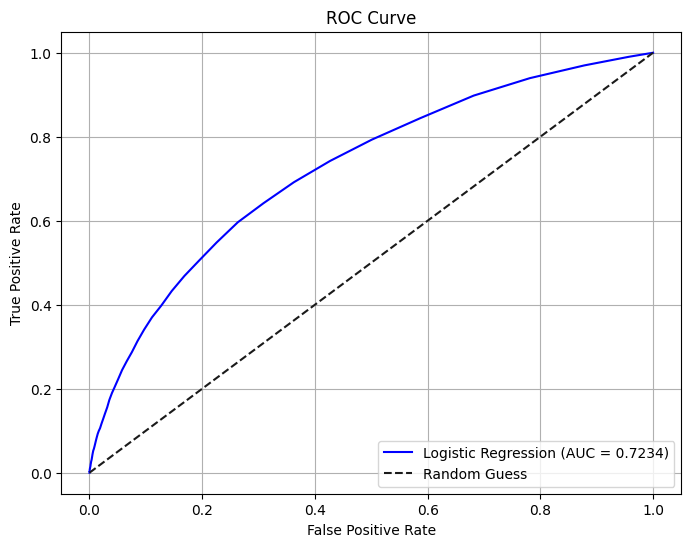

Train Accuracy: 1.000
Test Accuracy: 0.919

Test Balanced Accuraccy: 0.506

Confusion Matrix:
 [[70589    98]
 [ 6107    84]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     70687
           1       0.46      0.01      0.03      6191

    accuracy                           0.92     76878
   macro avg       0.69      0.51      0.49     76878
weighted avg       0.88      0.92      0.88     76878

The custom credit score is : 0.103


In [1331]:
# Evaluate the model

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}\n')
print(f'Test Balanced Accuraccy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))
print(f'The custom credit score is : {custom_loan_score:.3f}')

ccl : The model shows an obvious overfitting issue. Even rebalancing the classes, the Random Forest model brings bad results. Let's explore now different boosting models.

# AdaBoost

AdaBoost (Adaptive Boosting) is an ensemble learning algorithm that combines multiple weak learners, typically shallow decision trees, into a strong classifier by focusing more on misclassified instances at each iteration.
The basic estimator must be parametered with balanced class weight.

## First AdaBoost model

In [242]:
# Define the AdaBoost model and hyperparameters
estimator = DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=42)  # Weak learner
n_estimators = 100
learning_rate = 0.5

adaboost = AdaBoostClassifier(
    estimator=estimator,
    n_estimators=n_estimators,
    learning_rate=learning_rate
)

# Combine preprocessing with AdaBoost model
pipeline = make_pipeline(preprocess_p, adaboost)

start_time = time.time()

with mlflow.start_run(run_name="AdaBoost"):    
    
    # Train on the training data
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    custom_loan_score = custom_credit_metric(y_test, y_test_pred) # custom metric    

    # Log parameters
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("estimator", estimator)

    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Custom Loan Score", custom_loan_score)

    # Log model
    mlflow.sklearn.log_model(adaboost, "AdaBoost_model")

end_time = time.time()
print(f"Processing time : {end_time - start_time:.2f} seconds")

2025/04/14 14:00:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run AdaBoost at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/f587d8bfc48e41ba860805951cc25d7a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859
Processing time : 248.54 seconds


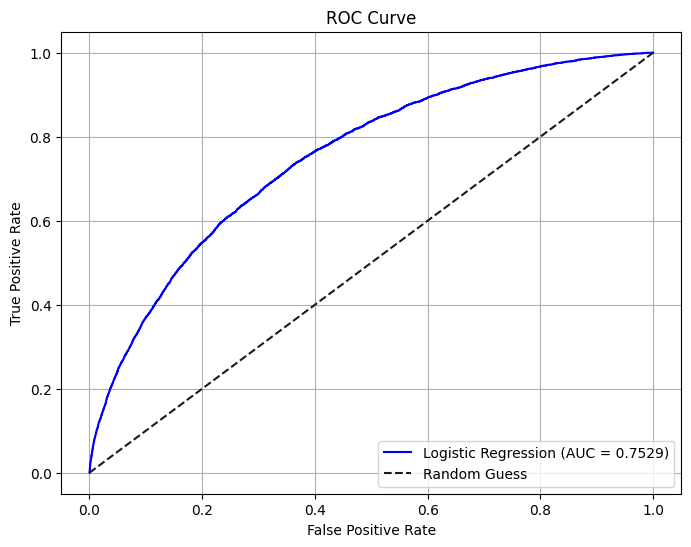

Train Accuracy: 0.687
Test Accuracy: 0.684

Test Balanced Accuraccy: 0.684

Confusion Matrix:
 [[48330 22357]
 [ 1953  4238]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.68      0.80     70687
           1       0.16      0.68      0.26      6191

    accuracy                           0.68     76878
   macro avg       0.56      0.68      0.53     76878
weighted avg       0.90      0.68      0.76     76878

The custom credit score is : 0.684


In [244]:
# Evaluate the model

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}\n')
print(f'Test Balanced Accuraccy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))
print(f'The custom credit score is : {custom_loan_score:.3f}')

Let's find out the opitmized hyperparameters using GridsearchCV.

## Optimization GridsearchCV

In order to speed up the processing time, we select the most important features, based on the previous experiences.

In [310]:
# Prepare data
X = app_train[key_feature_list.index] # 50 key features according to correlation vs target
X['CREDIT_INCOME_PERCENT'] = app_train_enriched['CREDIT_INCOME_PERCENT']
X['ANNUITY_INCOME_PERCENT'] = app_train_enriched['ANNUITY_INCOME_PERCENT']
X['CREDIT_TERM'] = app_train_enriched['CREDIT_TERM']
X['DAYS_EMPLOYED_PERCENT'] = app_train_enriched['DAYS_EMPLOYED_PERCENT']

y = app_train['TARGET']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [312]:
X.shape

(307511, 54)

In [320]:
# Define the AdaBoost model and hyperparameters
estimator = DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=42)  # Weak learner
adaboost = AdaBoostClassifier(estimator=estimator)

# Combine preprocessing with AdaBoost model
pipeline = make_pipeline(preprocess_p, adaboost)

# Define grid of hyperparameters
param_grid = {
    'adaboostclassifier__n_estimators': [50, 100, 200],
    'adaboostclassifier__learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Create GridSearchCV wrapper
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='recall', # since Recall is the key metrics in our case
    cv=5,
    verbose=2,
    n_jobs=-1
)

start_time = time.time()

with mlflow.start_run(run_name="AdaBoost"):

    # Run GridSearch
    grid_search.fit(X_train, y_train)

    # Best pipeline and parameters
    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Predictions
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = best_pipeline.predict(X_train)
    y_test_pred = best_pipeline.predict(X_test)

    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    custom_loan_score = custom_credit_metric(y_test, y_test_pred) # custom metric    

    # Log best hyperparameters
    mlflow.log_param("Best n_estimators", best_params['adaboostclassifier__n_estimators'])
    mlflow.log_param("Best learning_rate", best_params['adaboostclassifier__learning_rate'])
    mlflow.log_param("estimator", estimator)

    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Custom Loan Score", custom_loan_score)

    # Log model
    mlflow.sklearn.log_model(best_pipeline.named_steps['adaboostclassifier'], "Best_AdaBoost_Model")

end_time = time.time()
print(f"Processing time : {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025/04/14 16:04:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run AdaBoost at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/a4a4c789380c41e19c2eb3ad84bc352e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859
Processing time : 733.95 seconds


In [322]:
best_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])),
                ('adaboostclassifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=1,
                                                                     random_state=42),
                                    learning_rate=0.5, n_estimators=200))])

In [324]:
best_params

{'adaboostclassifier__learning_rate': 0.5,
 'adaboostclassifier__n_estimators': 200}

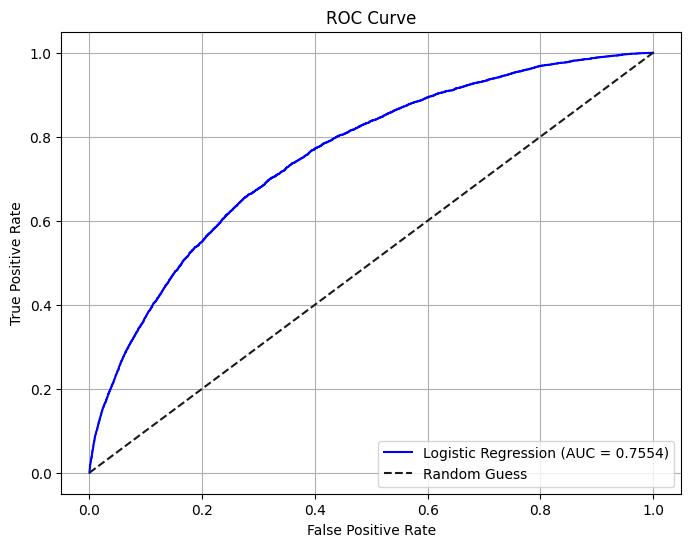

Train Accuracy: 0.698
Test Accuracy: 0.696

Test Balanced Accuraccy: 0.688

Confusion Matrix:
 [[49313 21374]
 [ 1989  4202]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     70687
           1       0.16      0.68      0.26      6191

    accuracy                           0.70     76878
   macro avg       0.56      0.69      0.54     76878
weighted avg       0.90      0.70      0.76     76878

The custom credit score is : 0.680


In [326]:
# Evaluate the model

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}\n')
print(f'Test Balanced Accuraccy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))
print(f'The custom credit score is : {custom_loan_score:.3f}')

In [330]:
# Feature importance

# Get the best model from pipeline, the feature names and feature importances
model = best_pipeline.named_steps['adaboostclassifier']
feature_names = X.columns.tolist()
importances = model.feature_importances_

# Create a DataFrame to associate feature names with their importance
coef_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
coef_df = coef_df.sort_values(by='Importance', ascending=False)
coef_df.head(10)

Feature  Importance
52        CREDIT_TERM       0.270
0        EXT_SOURCE_3       0.095
46         AMT_CREDIT       0.090
28    AMT_GOODS_PRICE       0.080
1        EXT_SOURCE_2       0.075
2        EXT_SOURCE_1       0.045
3          DAYS_BIRTH       0.040
29        OWN_CAR_AGE       0.035
12    DAYS_ID_PUBLISH       0.030
26  DAYS_REGISTRATION       0.020

ccl : AdaBoost gives interesting results but is slow for large data.

# GradientBoosting

In [354]:
X.shape

(307511, 54)

In [356]:
# Gradient Boosting model (no class_weight param !)
gbc = GradientBoostingClassifier(random_state=42, verbose=2)
pipeline = make_pipeline(preprocess_p, gbc)

param_grid = {
    'gradientboostingclassifier__n_estimators': [50, 100],
    'gradientboostingclassifier__learning_rate': [0.1, 0.5],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

# Create stratified CV splitter
# Every training/validation split keeps the same class distribution as the original dataset.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',  # also try 'roc_auc' and 'balanced_accuracy'
    cv=cv,
    verbose=3,
    n_jobs=-1
)

start_time = time.time()

with mlflow.start_run(run_name="GradientBoosting"):

    # Run GridSearch
    grid_search.fit(X_train, y_train)

    # Best pipeline and parameters
    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Predictions
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = best_pipeline.predict(X_train)
    y_test_pred = best_pipeline.predict(X_test)

    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    custom_loan_score = custom_credit_metric(y_test, y_test_pred) # custom metric    

    # Log params
    mlflow.log_params(grid_search.best_params_)

    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Custom Loan Score", custom_loan_score)

    # Log model
    mlflow.sklearn.log_model(best_pipeline, "gradient_boosting_model")

end_time = time.time()
print(f"Processing time : {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025/04/14 18:44:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run GradientBoosting at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/f0ed4f7ea7744b7391943c942246c139
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859
Processing time : 969.60 seconds


In [360]:
best_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.5, max_depth=5,
                                            random_state=42))])

In [362]:
best_params

{'gradientboostingclassifier__learning_rate': 0.5,
 'gradientboostingclassifier__max_depth': 5,
 'gradientboostingclassifier__n_estimators': 100}

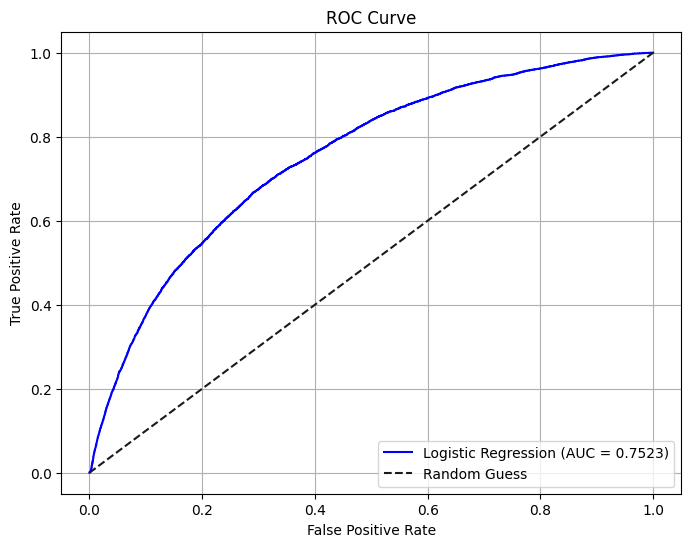

Train Accuracy: 0.928
Test Accuracy: 0.915

Test Balanced Accuraccy: 0.523

Confusion Matrix:
 [[69986   701]
 [ 5845   346]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96     70687
           1       0.33      0.06      0.10      6191

    accuracy                           0.91     76878
   macro avg       0.63      0.52      0.53     76878
weighted avg       0.88      0.91      0.89     76878

The custom credit score is : 0.141


In [358]:
# Evaluate the model

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}\n')
print(f'Test Balanced Accuraccy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))
print(f'The custom credit score is : {custom_loan_score:.3f}')

In [364]:
# Feature importance

# Get the best model from pipeline, the feature names and feature importances
model = best_pipeline.named_steps['gradientboostingclassifier']
feature_names = X.columns.tolist()
importances = model.feature_importances_

# Create a DataFrame to associate feature names with their importance
coef_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
coef_df = coef_df.sort_values(by='Importance', ascending=False)
coef_df.head(10)

Feature  Importance
0            EXT_SOURCE_3    0.199337
1            EXT_SOURCE_2    0.196010
52            CREDIT_TERM    0.102065
2            EXT_SOURCE_1    0.073857
3              DAYS_BIRTH    0.051840
12        DAYS_ID_PUBLISH    0.034099
53  DAYS_EMPLOYED_PERCENT    0.030442
46             AMT_CREDIT    0.030080
4           DAYS_EMPLOYED    0.029810
26      DAYS_REGISTRATION    0.025143

ccl : There is no class balancing native option with GradientBoosting scikit-learn model. As a consequence the Recall is much lower than with model with class balancing option. The model is also slow.

# XGBoost

In [393]:
#pip install xgboost

## XGBoost model

XGBoost supports built-in class balancing using scale_pos_weight = (num_negative / num_positive)

In [328]:
# Target imbalanced
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [330]:
# calculate ratio
scale_pos_weight = app_train['TARGET'].value_counts()[0] / app_train['TARGET'].value_counts()[1]
scale_pos_weight

11.387150050352467

In [553]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

pipeline = make_pipeline(preprocess_p, xgb)

param_grid = {
    'xgbclassifier__n_estimators': [50, 100],
    'xgbclassifier__learning_rate': [0.1, 0.3],
    'xgbclassifier__max_depth': [3, 5],
    'xgbclassifier__scale_pos_weight': [11, 15, 20]  # try several weights around known ratio
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,  # try recall/roc_auc/custom_scorer
    cv=5,
    verbose=3,
    n_jobs=-1
)

start_time = time.time()

with mlflow.start_run(run_name="XGBoost"):

    # Run GridSearch
    grid_search.fit(X_train, y_train)

    # Best pipeline and parameters
    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Predictions
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = best_pipeline.predict(X_train)
    y_test_pred = best_pipeline.predict(X_test)

    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    custom_loan_score = custom_credit_metric(y_test, y_test_pred) # custom metric    

    # Log best hyperparameters
    mlflow.log_params(grid_search.best_params_)
    
    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Custom Loan Score", custom_loan_score)

    # Log model
    mlflow.sklearn.log_model(best_pipeline, "Best_XGBoost_Model")

end_time = time.time()
print(f"Processing time : {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/04/15 18:11:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/e8322cabf7a14fd8a97ad94c57242da4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859
Processing time : 178.80 seconds


In [555]:
best_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feat...hts=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [557]:
best_params

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 50,
 'xgbclassifier__scale_pos_weight': 20}

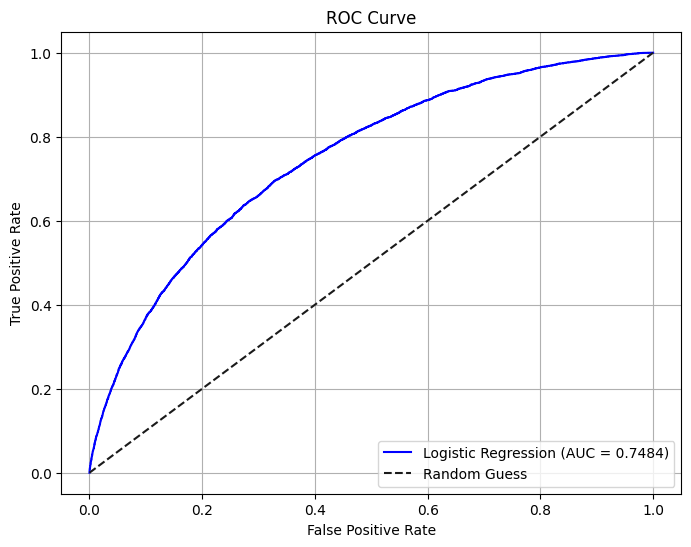

Train Accuracy: 0.456
Test Accuracy: 0.454

Test Balanced Accuraccy: 0.648

Confusion Matrix:
 [[29447 41240]
 [  750  5441]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.42      0.58     70687
           1       0.12      0.88      0.21      6191

    accuracy                           0.45     76878
   macro avg       0.55      0.65      0.39     76878
weighted avg       0.91      0.45      0.55     76878

The custom credit score is : 0.837


In [559]:
# Evaluate the model

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}\n')
print(f'Test Balanced Accuraccy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))
print(f'The custom credit score is : {custom_loan_score:.3f}')

In [561]:
# Feature importance

# Get the best model from pipeline, the feature names and feature importances
xgb_model = best_pipeline.named_steps['xgbclassifier']
feature_names = X.columns.tolist()
importances = xgb_model.feature_importances_

# Create a DataFrame to associate feature names with their importance
coef_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
coef_df = coef_df.sort_values(by='Importance', ascending=False)
coef_df.head(10)

Feature  Importance
0                                        EXT_SOURCE_3    0.150025
1                                        EXT_SOURCE_2    0.121877
8                NAME_EDUCATION_TYPE_Higher education    0.067007
4                                       DAYS_EMPLOYED    0.059438
2                                        EXT_SOURCE_1    0.050031
10                                      CODE_GENDER_M    0.048887
52                                        CREDIT_TERM    0.042772
29                                        OWN_CAR_AGE    0.030693
20                                    FLAG_DOCUMENT_3    0.029658
14  NAME_EDUCATION_TYPE_Secondary / secondary special    0.029590

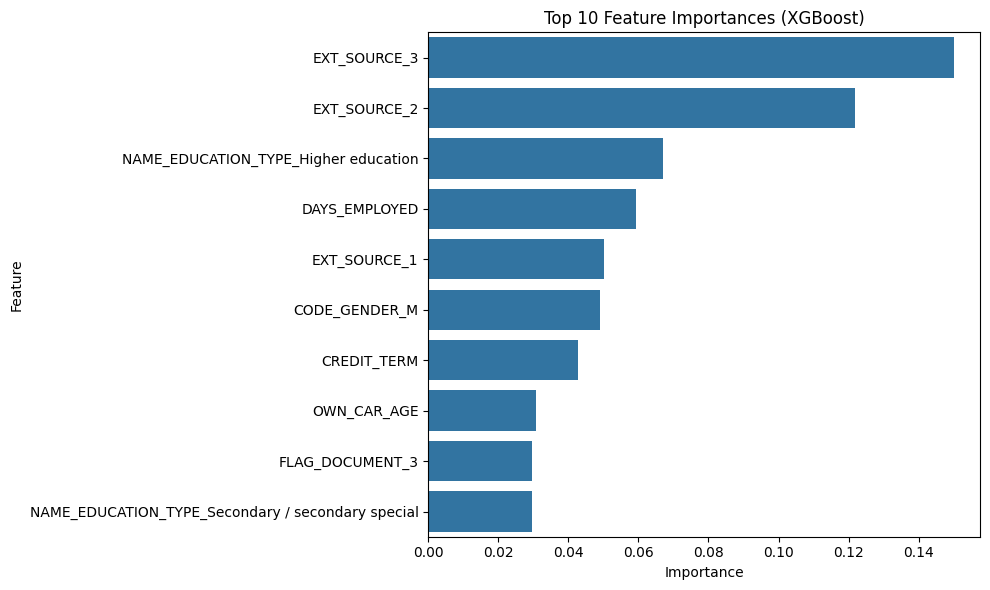

In [563]:
# Display the Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=coef_df.head(10))
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

ccl : XGBoost is very fast and performant compared to other models. Choosing 'recall' or 'roc_auc' scoring in GridSearchCV will notably influence the targeted metrics. The customized scorer has finally been used. XGBoost gives the best results so far. The scale_pos_weight hyperparameter allows to handle imbalanced classes issue.

## SHAP interpretability on XGBoost

SHAP (SHapley Additive exPlanations) is based on game theory. For each prediction, it computes how much each feature contributes to moving the prediction away from the average.

Global interpretability aims to explain the overall behavior of the model across all predictions. It provides insights into how the model makes decisions across the entire dataset and how features generally affect the model’s predictions.

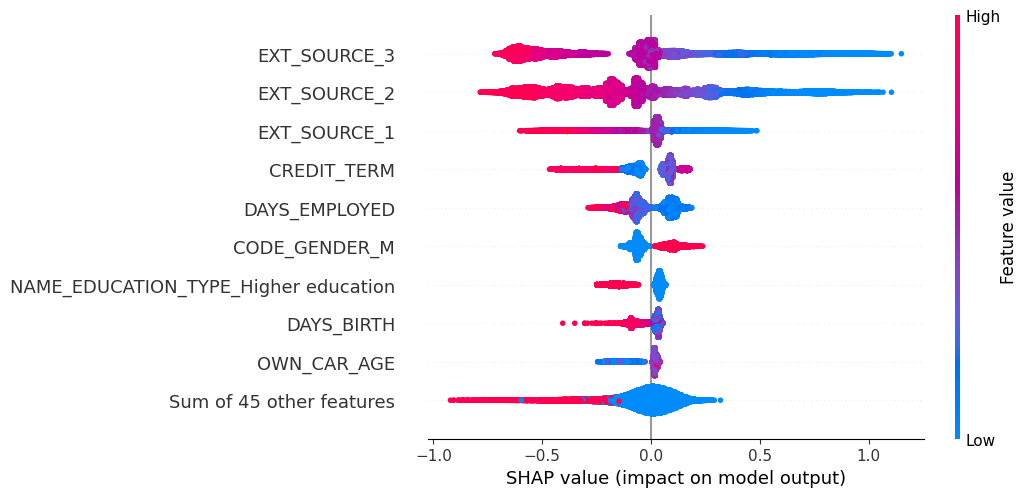

In [571]:
# XGBoost Global interpretability

# Get preprocessed data
X_processed = preprocess_p.transform(X_test)

# Get XGBoost model
xgb_model = best_pipeline.named_steps['xgbclassifier']

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_processed)
shap_values.feature_names = X.columns.tolist()

# Summary plot
shap.plots.beeswarm(shap_values)

Interpretation :

 - A positive SHAP value indicates that the feature pushes the prediction closer to 1 (the class of "loan not repaid" or default).

 - A negative SHAP value indicates that the feature pushes the prediction closer to 0 (the class of "loan repaid")

ccl : XGBoost is significantly faster than other models. It can balance classes using the scale_pos_weight hyperparameter, which greatly improves performance. XGBoost delivers the best performance so far. Interestingly, submitting the scale_pos_weight hyperparameter to GridSearchCV yields optimal performance with a higher value than the calculated one.

# LightGBM

LightGBM (Light Gradient Boosting Machine) is a gradient boosting framework developed by Microsoft. It is based on decision tree algorithms and is designed to be faster and more memory-efficient than other implementations like XGBoost. LightGBM uses a leaf-wise tree growth strategy, which means it grows the tree by splitting the leaf with the highest delta loss. This typically leads to better accuracy than the level-wise approach. LightGBM automatically handles missing values in the data by treating them as a separate category and building the tree accordingly. The disadvantages of this model are the overfitting risk and the sensitivity of hyperparameters tuning.

In [480]:
#pip install lightgbm

In [334]:
# imbalanced class ratio
scale_pos_weight

11.387150050352467

In [534]:
lgbm = LGBMClassifier(
    objective='binary',
    eval_metric='binary_logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

pipeline = make_pipeline(preprocess_p, lgbm)

param_grid = {
    'lgbmclassifier__n_estimators': [50, 100],
    'lgbmclassifier__learning_rate': [0.1, 0.3],
    'lgbmclassifier__max_depth': [3, 5],
    'lgbmclassifier__scale_pos_weight': [10, 15, 20]  # try several weights around known ratio
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,  # try recall/roc_auc/custom_scorer
    cv=5,
    verbose=3,
    n_jobs=-1
)

start_time = time.time()

with mlflow.start_run(run_name="LightGBM"):

    # Run GridSearch
    grid_search.fit(X_train, y_train)

    # Best pipeline and parameters
    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Predictions
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = best_pipeline.predict(X_train)
    y_test_pred = best_pipeline.predict(X_test)

    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    custom_loan_score = custom_credit_metric(y_test, y_test_pred) # custom metric    

    # Log best hyperparameters
    mlflow.log_params(grid_search.best_params_)
    
    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Custom Loan Score", custom_loan_score)

    # Log model
    mlflow.sklearn.log_model(best_pipeline, "Best_LighGBM_Model")

end_time = time.time()
print(f"Processing time : {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 18634, number of negative: 211999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5658
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080795 -> initscore=-2.431594
[LightGBM] [Info] Start training from score -2.431594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

2025/04/15 17:45:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/aa3139bc6ce64154a16adc1e8802b3be
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859
Processing time : 188.40 seconds


In [536]:
best_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])),
                ('lgbmclassifier',
                 LGBMClassifier(eval_metric='binary_logloss', max_depth=3,
                                n_estimators=50, objective='binary',
                                random_state=42, scale_pos_weight=20))])

In [538]:
best_params

{'lgbmclassifier__learning_rate': 0.1,
 'lgbmclassifier__max_depth': 3,
 'lgbmclassifier__n_estimators': 50,
 'lgbmclassifier__scale_pos_weight': 20}

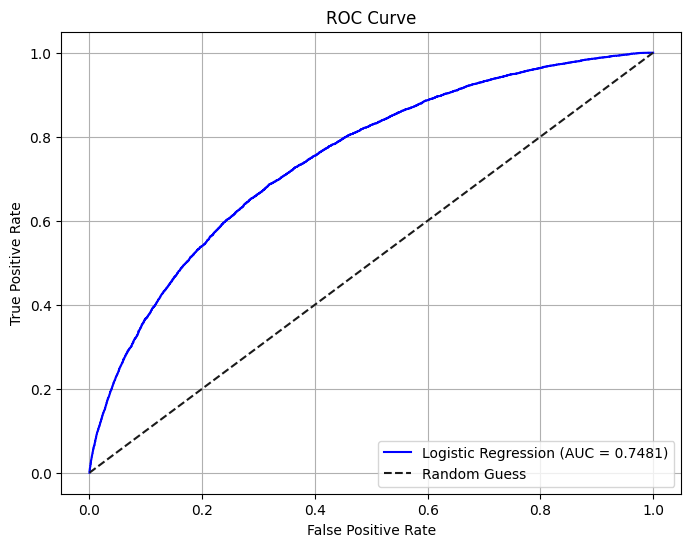

Train Accuracy: 0.460
Test Accuracy: 0.457

Test Balanced Accuraccy: 0.647

Confusion Matrix:
 [[29735 40952]
 [  779  5412]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.42      0.59     70687
           1       0.12      0.87      0.21      6191

    accuracy                           0.46     76878
   macro avg       0.55      0.65      0.40     76878
weighted avg       0.91      0.46      0.56     76878

The custom credit score is : 0.833


In [540]:
# Evaluate the model

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}\n')
print(f'Test Balanced Accuraccy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))
print(f'The custom credit score is : {custom_loan_score:.3f}')

In [542]:
# Feature importance

# Get the best model from pipeline, the feature names and feature importances
xgb_model = best_pipeline.named_steps['lgbmclassifier']
feature_names = X.columns.tolist()
importances = xgb_model.feature_importances_

# Create a DataFrame to associate feature names with their importance
coef_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
coef_df = coef_df.sort_values(by='Importance', ascending=False)
coef_df.head(10)

Feature  Importance
0         EXT_SOURCE_3          70
1         EXT_SOURCE_2          53
52         CREDIT_TERM          36
2         EXT_SOURCE_1          31
3           DAYS_BIRTH          17
4        DAYS_EMPLOYED          15
46          AMT_CREDIT          14
10       CODE_GENDER_M          14
44  NAME_CONTRACT_TYPE          12
29         OWN_CAR_AGE          10

ccl : LightGBM is fast and matches XGBoost's performance. The model can balance classes using the scale_pos_weight hyperparameter, significantly improving performance.

# Downsampling and upsampling

Comparing all tested model, LogisticRegression, Random Forest, AdaBoost, GradientBoosting, XGBoost and LightGBM, the most intersting model is XGBoost, based on custom metric (0.84), recall (0.88) and processing speed. Additionally, XGBoost provides an effective way to handle class imbalance through the scale_pos_weight hyperparameter, which is crucial for this project.

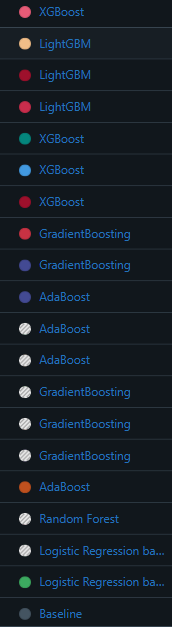

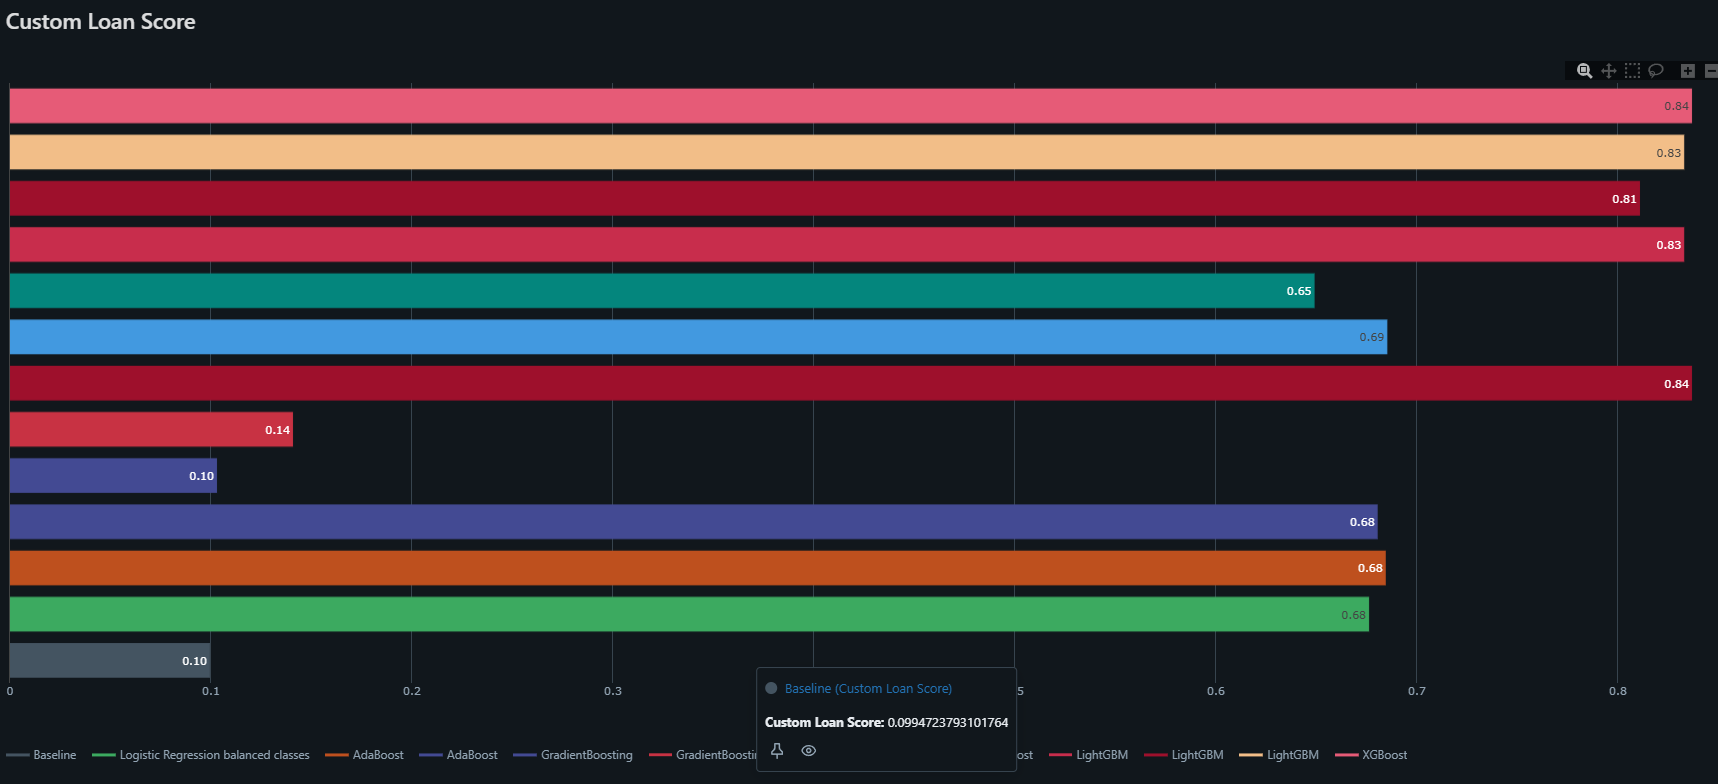

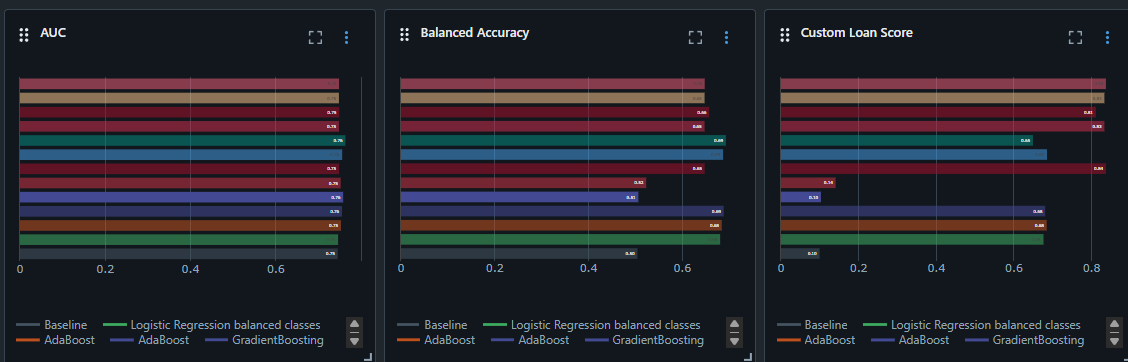

We are now going to run the XGBoost model on the comprehensive dataset, including feature engineering (polynomial features based on 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3' and 'DAYS_BIRTH') and 4 business tailor-made features.


In [345]:
# Prepare data
X = app_train_enriched.drop(columns=['TARGET'])
y = app_train_enriched['TARGET']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [346]:
X_train.shape

(230633, 281)

warning ! The model can not be run on the full (230633, 281) train set with GrirdSearchCV because of insuffisant memory ressources on my PC.

## Downsampling

Downsampling reduces the size of the majority class to balance the dataset, which helps prevent the model from being biased toward the dominant class. It also lowers computational cost, making it feasible to train models and perform hyperparameter tuning like GridSearchCV on large datasets.

In [394]:
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler

In [513]:
# Prepare data
X = app_train_enriched.drop(columns=['TARGET'])
y = app_train_enriched['TARGET']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

### Manual random down sampling

In [353]:
# Concatenate X and y for easy handling
train_df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority
df_majority = train_df[train_df['TARGET'] == 0]
df_minority = train_df[train_df['TARGET'] == 1]

print('df_majority shape : ', df_majority.shape)
print('df_minority shape : ', df_minority.shape)

df_majority shape :  (211999, 282)
df_minority shape :  (18634, 282)


In [355]:
# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False, #ensure no duplicated rows
                                   n_samples=len(df_minority)*1,  # try 1:1 or 2:1
                                   random_state=42)

# Combine back
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset
df_downsampled = df_downsampled.sample(frac=1, random_state=42)

X_train_down = df_downsampled.drop(columns=['TARGET'])
y_train_down = df_downsampled['TARGET']

print('X_train_down shape : ', X_train_down.shape)
print('y_train_down shape : ', y_train_down.shape)

X_train_down shape :  (37268, 281)
y_train_down shape :  (37268,)


### Class imblearn.under_sampling.RandomUnderSampler

The imblearn library has an ``RandomUnderSampler`` in-built class to perform random under-sampling, that is easy to use.

In [517]:
#pip install imbalanced-learn

In [519]:
# Create the sampler
rand_downsampl = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply it to the training data
X_train_downsampl, y_train_downsampl = rand_downsampl.fit_resample(X_train, y_train)

print('X_train_downsampl shape : ', X_train_downsampl.shape)
print('y_train_downsampl shape : ', y_train_downsampl.shape)

# Verify balanced class
y_train_downsampl.value_counts()

X_train_downsampl shape :  (37238, 281)
y_train_downsampl shape :  (37238,)


TARGET
0    18619
1    18619
Name: count, dtype: int64

In [541]:
# Run XGBoost model with random downsampling data
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=1 # since downsampling method is running
)

pipeline = make_pipeline(preprocess_p, xgb)

param_grid = {
    'xgbclassifier__n_estimators': [50, 100, 200],
    'xgbclassifier__learning_rate': [0.1, 0.2, 0.3],
    'xgbclassifier__max_depth': [3, 4, 5]
    #'xgbclassifier__scale_pos_weight': [1, 10, 20]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    #scoring=custom_scorer,  # custom_scorer
    scoring='roc_auc',  # more balanced metrics
    cv=4,
    verbose=3,
    n_jobs=-1
)

start_time = time.time()

with mlflow.start_run(run_name="Down_sampl_XGBoost"):

    # Run GridSearch
    grid_search.fit(X_train_downsampl, y_train_downsampl)

    # Best pipeline and parameters
    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Predictions
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = best_pipeline.predict(X_train_downsampl)
    y_test_pred = best_pipeline.predict(X_test)

    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train_downsampl, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    custom_loan_score = custom_credit_metric(y_test, y_test_pred) # custom metric    

    # Log best hyperparameters
    mlflow.log_params(grid_search.best_params_)
    
    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Custom Loan Score", custom_loan_score)

    # Log model
    mlflow.sklearn.log_model(best_pipeline, "Down_sampl_XGBoost_Model")

end_time = time.time()
print(f"Processing time : {end_time - start_time:.2f} seconds")

Fitting 4 folds for each of 27 candidates, totalling 108 fits


2025/04/21 11:44:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Down_sampl_XGBoost at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/bc2288c397654a6bb83b8236d40d43a1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859
Processing time : 121.50 seconds


In [543]:
best_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feat...ts=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [545]:
best_params

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 4,
 'xgbclassifier__n_estimators': 200}

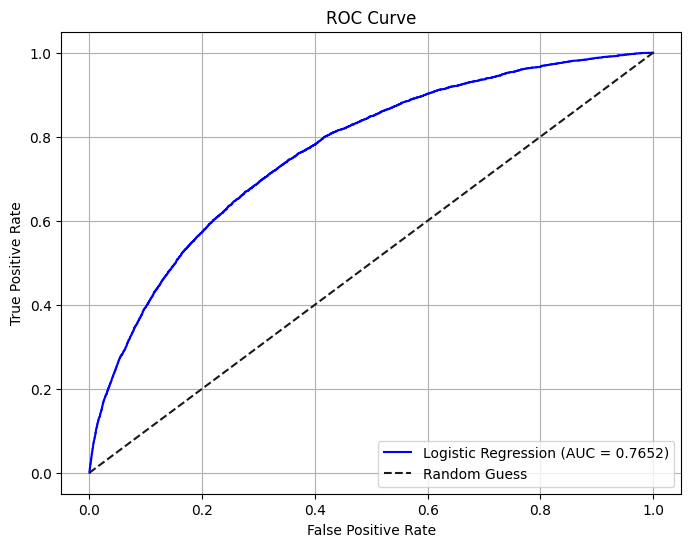

Train Accuracy: 0.733
Test Accuracy: 0.693

Test Balanced Accuraccy: 0.696

Confusion Matrix:
 [[48913 21759]
 [ 1865  4341]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.81     70672
           1       0.17      0.70      0.27      6206

    accuracy                           0.69     76878
   macro avg       0.56      0.70      0.54     76878
weighted avg       0.90      0.69      0.76     76878

The custom credit score is : 0.699


In [547]:
# Evaluate the model

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}\n')
print(f'Test Balanced Accuraccy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))
print(f'The custom credit score is : {custom_loan_score:.3f}')

In [549]:
# Feature importance

# Get the best model from pipeline, the feature names and feature importances
xgb_model = best_pipeline.named_steps['xgbclassifier']
feature_names = X.columns.tolist()
importances = xgb_model.feature_importances_

# Create a DataFrame to associate feature names with their importance
coef_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
coef_df = coef_df.sort_values(by='Importance', ascending=False)
coef_df.head(10)

Feature  Importance
262  EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3    0.139323
271    EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.061019
127    NAME_EDUCATION_TYPE_Higher education    0.023228
67                           ELEVATORS_MEDI    0.018898
33                           EXT_SOURCE_3_x    0.015199
108                           CODE_GENDER_F    0.014786
1                        NAME_CONTRACT_TYPE    0.012540
268             EXT_SOURCE_2^2 EXT_SOURCE_3    0.012337
83                          FLAG_DOCUMENT_3    0.010729
270             EXT_SOURCE_2 EXT_SOURCE_3^2    0.010583

ccl : We have used a random downsampling method to determine the best hyperparameters with GridSearchCV. We'll now use SMOTE the generate synthetic samples of the "0" class.

## SMOTE

SMOTE is a popular technique to handle class imbalance, especially for binary classification like loan repayment prediction. SMOTE stands for Synthetic Minority Oversampling Technique. Instead of duplicating minority samples (which can lead to overfitting), SMOTE generates new synthetic examples of the minority class by interpolation.

In [585]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [587]:
# Best XGBoost parameters from previous Random Downsampling run
best_params

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 4,
 'xgbclassifier__n_estimators': 200}

In [560]:
# Prepare data
X = app_train_enriched.drop(columns=['TARGET'])
y = app_train_enriched['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Define preprocessing pipeline
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('xgb', XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            scale_pos_weight=1, # 15 better !!!
            random_state=42,
            learning_rate=best_params['xgbclassifier__learning_rate'],
            max_depth=best_params['xgbclassifier__max_depth'],
            n_estimators=best_params['xgbclassifier__n_estimators']))
    ])

In [562]:
start_time = time.time()

with mlflow.start_run(run_name="SMOTE_XGBoost"):

    # Train on the training data
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    custom_loan_score = custom_credit_metric(y_test, y_test_pred) # custom metric    

    # Log best hyperparameters
    mlflow.log_params(grid_search.best_params_) # from previous run
    
    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Custom Loan Score", custom_loan_score)

    # Log model
    mlflow.sklearn.log_model(pipeline, "SMOTE_XGBoost_Model")

end_time = time.time()
print(f"Processing time : {end_time - start_time:.2f} seconds")

2025/04/21 11:47:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SMOTE_XGBoost at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/0f05e38238554e41a33347366ee23fca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859
Processing time : 31.68 seconds


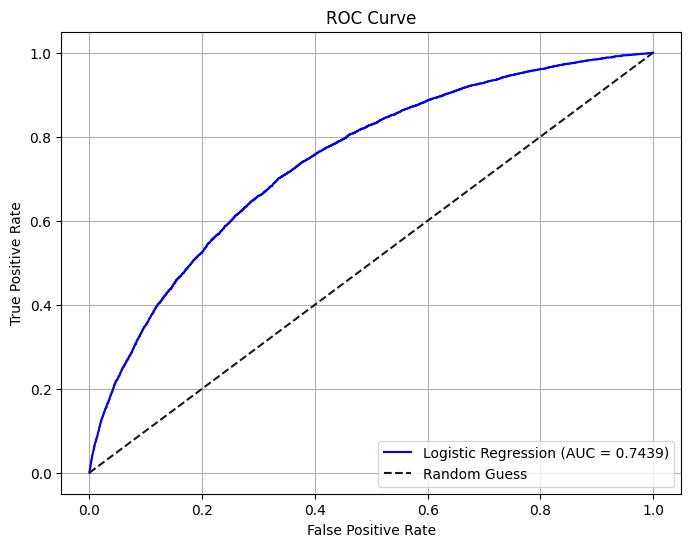

Train Accuracy: 0.920
Test Accuracy: 0.919

Test Balanced Accuraccy: 0.505

Confusion Matrix:
 [[70580    92]
 [ 6139    67]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     70672
           1       0.42      0.01      0.02      6206

    accuracy                           0.92     76878
   macro avg       0.67      0.50      0.49     76878
weighted avg       0.88      0.92      0.88     76878

The custom credit score is : 0.101


In [564]:
# Evaluate the model

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}\n')
print(f'Test Balanced Accuraccy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))
print(f'The custom credit score is : {custom_loan_score:.3f}')

### Double-checking - Without using a pipeline

In [589]:
# Prepare data
X = app_train_enriched.drop(columns=['TARGET'])
y = app_train_enriched['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [619]:

# 1. Split the original dataset
X = app_train_enriched.drop(columns=['TARGET'])
y = app_train_enriched['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# 2. Impute and scale
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 3. Apply SMOTE to training data only
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 4. Train XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=200,
    scale_pos_weight=1  # SMOTE balances the classes
)

start_time = time.time()
xgb.fit(X_train_smote, y_train_smote)

# 5. Evaluate
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)
y_test_proba = xgb.predict_proba(X_test_scaled)[:, 1]

# 6. Metrics
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("AUC:", roc_auc_score(y_test, y_test_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

end_time = time.time()
print(f"Processing time: {end_time - start_time:.2f} seconds")


Train Accuracy: 0.9195821933548105
Test Accuracy: 0.918949504409584
Balanced Accuracy: 0.5047471076614822
Precision: 0.42138364779874216
Recall: 0.010796003867225266
AUC: 0.743890049110784

Confusion Matrix:
 [[70580    92]
 [ 6139    67]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     70672
           1       0.42      0.01      0.02      6206

    accuracy                           0.92     76878
   macro avg       0.67      0.50      0.49     76878
weighted avg       0.88      0.92      0.88     76878

Processing time: 13.37 seconds


In [620]:
X_train_smote.shape

(424028, 281)

In [621]:
y_train_smote.shape

(424028,)

In [610]:
y_train_smote.value_counts()

TARGET
0    212014
1    212014
Name: count, dtype: int64

In [613]:
X_train.shape

(230633, 281)

ccl : ?

In [698]:
from sklearn.metrics import ConfusionMatrixDisplay

# Best Model

## Best XGBoost model

XGBoost best model with hyperparameters determined with GridSearCV.

In [702]:
# Prepare data
X = app_train_enriched.drop(columns=['TARGET'])
y = app_train_enriched['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Define preprocessing pipeline
preprocess_p = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

xgb = XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            scale_pos_weight=20, # TBC !
            random_state=42,
            learning_rate=0.1,
            max_depth=4,
            n_estimators=200)

# Combine preprocessing with XGBoost model
pipeline = make_pipeline(preprocess_p, xgb)

2025/04/22 12:24:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Best_Model_XGBoost at: http://127.0.0.1:5000/#/experiments/627297881201483859/runs/c51cf9f4f35843f8820b4195c81686d6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/627297881201483859
Processing time : 21.44 seconds


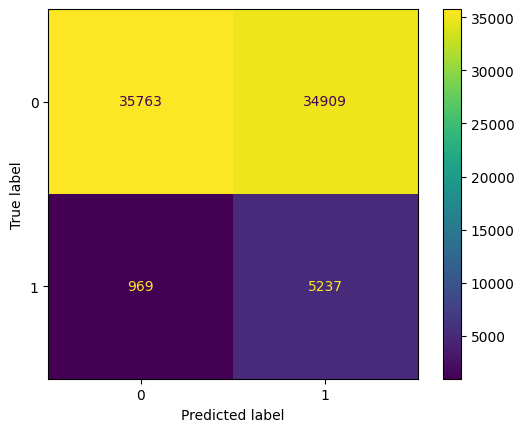

In [704]:
start_time = time.time()

with mlflow.start_run(run_name="Best_Model_XGBoost"):

    # Train on the training data
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Metrics    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    custom_loan_score = custom_credit_metric(y_test, y_test_pred) # custom metric    

    # Log best hyperparameters
    mlflow.log_params(xgb.get_params())
    
    # Log metrics
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Train Accuracy", train_acc)
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Balanced Accuracy", balanced_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Custom Loan Score", custom_loan_score)

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log model
    mlflow.sklearn.log_model(pipeline, "Master_Model")

end_time = time.time()
print(f"Processing time : {end_time - start_time:.2f} seconds")

In [706]:
pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feat...ts=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

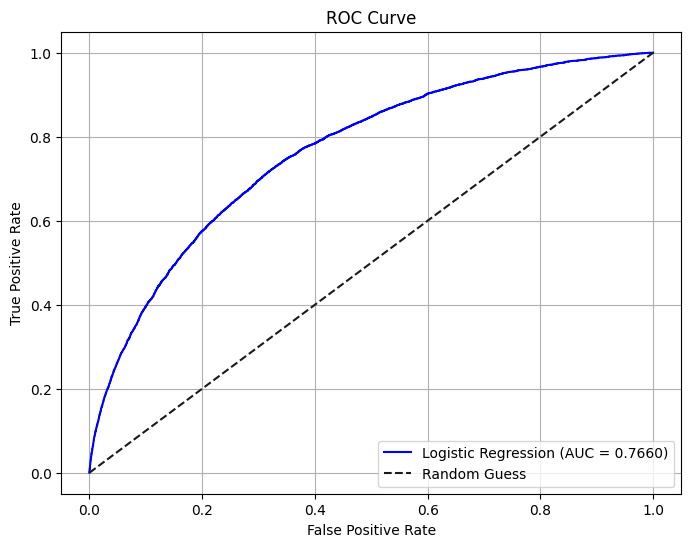

Train Accuracy: 0.540
Test Accuracy: 0.533

Test Balanced Accuraccy: 0.675

Confusion Matrix:
 [[35763 34909]
 [  969  5237]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.51      0.67     70672
           1       0.13      0.84      0.23      6206

    accuracy                           0.53     76878
   macro avg       0.55      0.67      0.45     76878
weighted avg       0.91      0.53      0.63     76878

The custom credit score is : 0.813


In [708]:
# Evaluate the model

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display metrics
print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}\n')
print(f'Test Balanced Accuraccy: {balanced_acc:.3f}\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report:\n', classification_report(y_test, y_test_pred))
print(f'The custom credit score is : {custom_loan_score:.3f}')

In [710]:
# Feature importance

# Get the best model from pipeline, the feature names and feature importances
xgb_model = best_pipeline.named_steps['xgbclassifier']
feature_names = X.columns.tolist()
importances = xgb_model.feature_importances_

# Create a DataFrame to associate feature names with their importance
coef_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
coef_df = coef_df.sort_values(by='Importance', ascending=False)
coef_df.head(10)

Feature  Importance
262  EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3    0.139323
271    EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.061019
127    NAME_EDUCATION_TYPE_Higher education    0.023228
67                           ELEVATORS_MEDI    0.018898
33                           EXT_SOURCE_3_x    0.015199
108                           CODE_GENDER_F    0.014786
1                        NAME_CONTRACT_TYPE    0.012540
268             EXT_SOURCE_2^2 EXT_SOURCE_3    0.012337
83                          FLAG_DOCUMENT_3    0.010729
270             EXT_SOURCE_2 EXT_SOURCE_3^2    0.010583

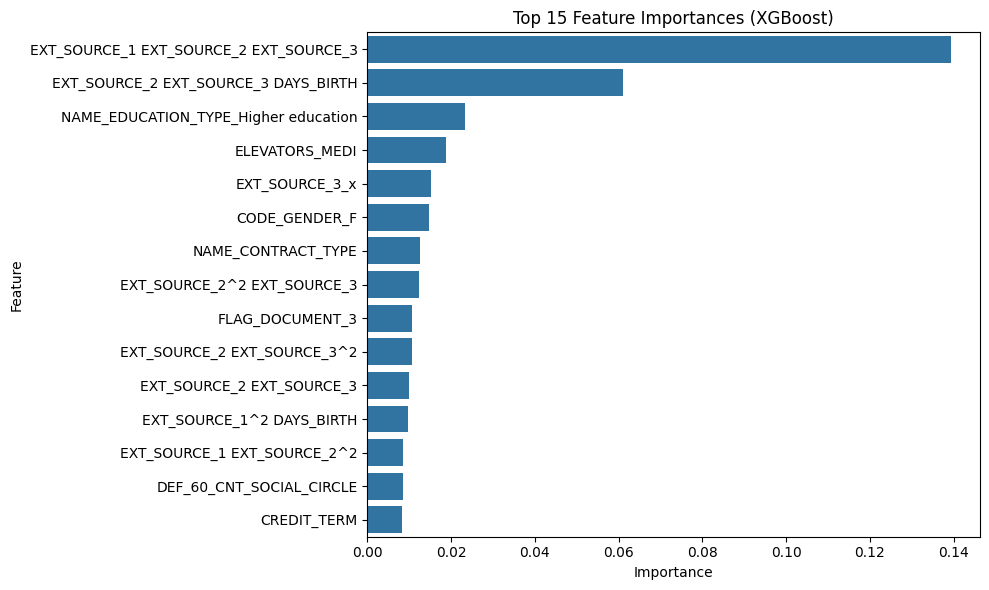

In [712]:
# Display the Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=coef_df.head(15))
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

## SHAP interpretability

SHAP (SHapley Additive exPlanations) is based on game theory. For each prediction, it computes how much each feature contributes to moving the prediction away from the average.

Global interpretability aims to explain the overall behavior of the model across all predictions. It provides insights into how the model makes decisions across the entire dataset and how features generally affect the model’s predictions.

### Global interpretability

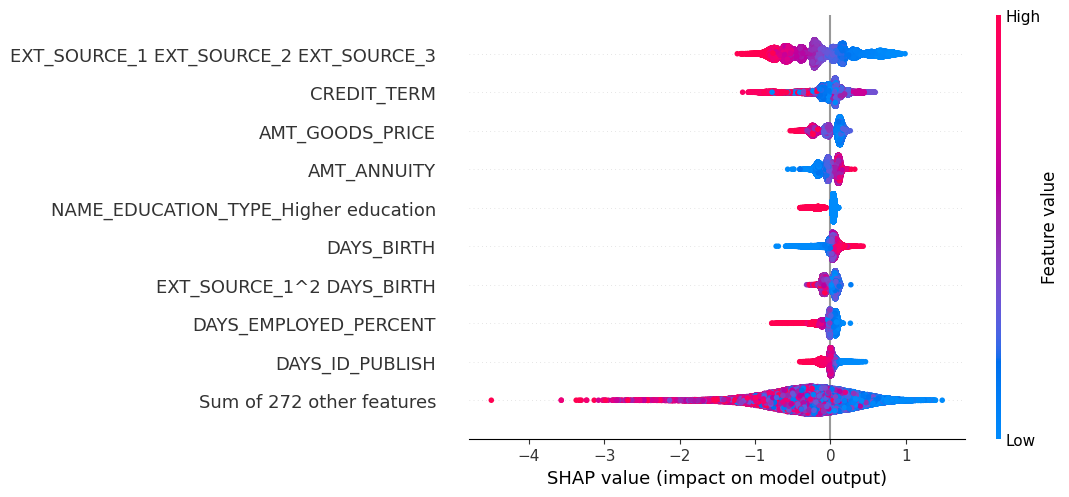

In [722]:
# XGBoost Global interpretability

# Get preprocessed data
X_processed = preprocess_p.transform(X_test)

# Get XGBoost model
xgb_model = pipeline.named_steps['xgbclassifier']

# Create SHAP explainer
explainer = shap.Explainer(xgb)

# Compute SHAP values
shap_values = explainer(X_processed)
shap_values.feature_names = X.columns.tolist()

# Summary plot
shap.plots.beeswarm(shap_values)

### Local interpretability

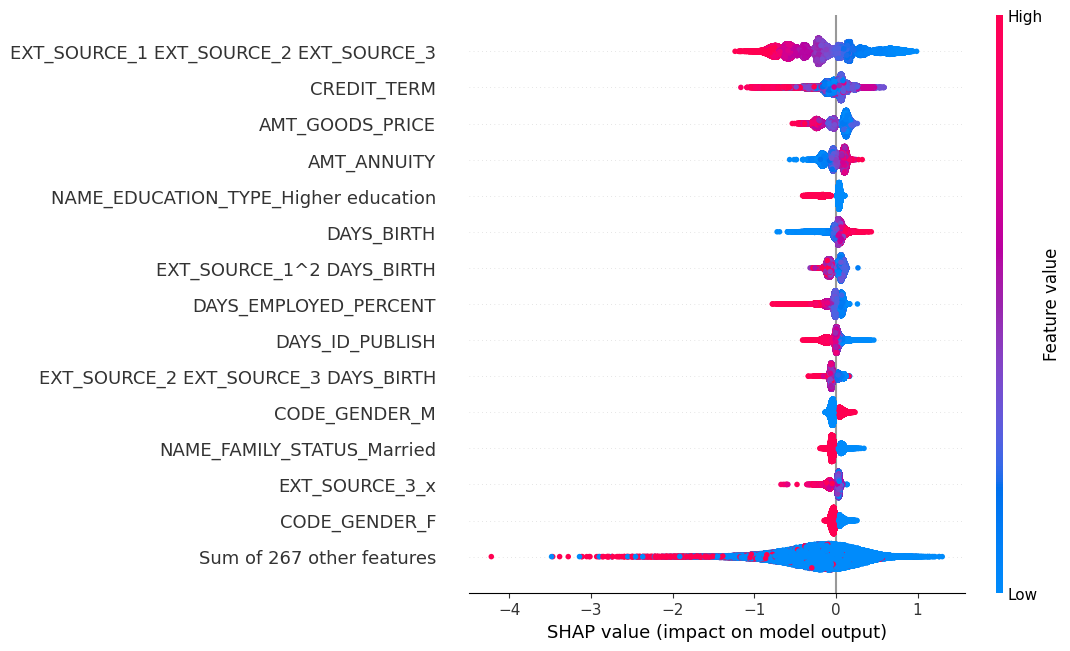

In [726]:
# XGBoost Model Global interpretability

# Get preprocessed data
X_processed = preprocess_p.transform(X_test)

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb) # optimized for tress models such as XGBoost

# Compute SHAP values
shap_values = explainer(X_processed)
shap_values.feature_names = X.columns.tolist()

# Summary plot
shap.plots.beeswarm(shap_values, max_display=15)

Interpretation :

 - A positive SHAP value indicates that the feature pushes the prediction closer to 1 (the class of "loan not repaid" or default).

 - A negative SHAP value indicates that the feature pushes the prediction closer to 0 (the class of "loan repaid")

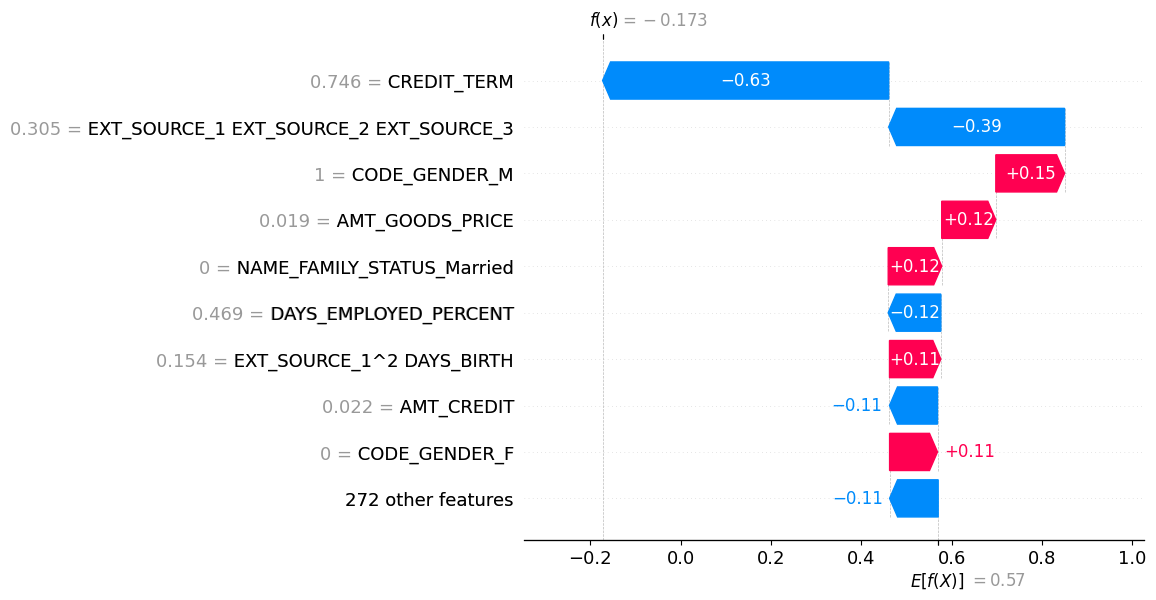

In [734]:
# Local interpretability
shap.plots.waterfall(shap_values[3])

ccl : For this specific case, a local interpretability can be done. The probability of class = 1 is P(class=1) = Sigmoid(-0.173) = 1/(1+exp(0.173) = 0.457. This means the model estimates 45.7% chance that this person will not repay the loan. That is to say 54.3% chances that the loan will be repaid. This estimation is mainly based on the "Credit Term" feature, that strongly reduces the risk, the engineered feature created by multiplying "Ext_source_1", "Ext_source_2" and "Ext_source_3", and the gender of the person. Being male slightly increases the risk. But overall, the model is cautiously optimistic about this client

ccl : Test GitHub modif
